## Modeling Notebook 1 (symmetric)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import scikitplot as skplt

sns.set(font_scale=1.5)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline



from sklearn import datasets, metrics, naive_bayes
from sklearn.preprocessing import StandardScaler, PowerTransformer

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split,cross_val_score, StratifiedKFold, GridSearchCV, KFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from matplotlib.colors import ListedColormap
from sklearn.svm import LinearSVC, SVC
from sklearn.neural_network import MLPClassifier

from six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
import scipy.stats as stats


def warn(*args, **kwargs):
    pass

import warnings
warnings.warn = warn

In [2]:
sns.set(style="ticks", context="talk")
plt.style.use("seaborn-darkgrid")

In [3]:
class full_classification:
    """A class which automatically does all classification models and gridsearches for you (logisitic default). 
    Remember to input baseline figure and decide if you want standardisation.
    Note: when you run a new model it will overwrite the previous model. You can access the current model with .model and .model_des.
    Created by LukeBetham"""

    def __init__(self, X, y, run_all=True, baseline=0, standardize=True, test_size=0.15, folds=6, shuffle=True, stratify=None,print_info=True, save_it=False, comment=None):

        # Save settings to object
        self.folds = folds
        self.shuffle = shuffle
        self.stratify= stratify
        # Option for bolding print text
        self.BOLD = '\033[1m'
        self.END = '\033[0m'
        # Create train-test if selected
        self.X = X
        self.y = y
        self.baseline = baseline
        self.test = test_size
        if self.test != 0:
#             self.X, self.X_test, self.y, self.y_test, self.index_train, self.index_test = train_test_split(
#                 self.X, self.y, self.X.index, test_size=self.test, shuffle=self.shuffle, stratify=self.stratify, random_state=66)
            self.X, self.X_test, self.y, self.y_test, self.index_train, self.index_test, self.Xf_train, self.Xf_test, self.yf_train, self.yf_test = train_test_split(
                self.X, self.y, self.X.index, X_flip, y_flip, test_size=self.test, shuffle=self.shuffle, stratify=self.stratify, random_state=66)
#         # Standardise the data if selected
        if standardize != 'none':
            scaler = StandardScaler()
            self.X = pd.DataFrame(
                scaler.fit_transform(self.X), columns=self.X.columns)
            if self.test != 0:
                self.X_test = pd.DataFrame(
                    scaler.transform(self.X_test), columns=self.X.columns)
#             Delete this bit when done
            self.Xf_train = pd.DataFrame(
                    scaler.fit_transform(self.Xf_train), columns=self.X.columns)
            self.Xf_test = pd.DataFrame(
                    scaler.transform(self.Xf_test), columns=self.X.columns)
        #Settings
        self.comment = comment
        self.save_it = save_it
        self.print_info = print_info
        # Call the 5 standard models
        if run_all==True:
            self.knn_model(5)
            self.decision_tree_model()
            self.logistic_model()
            self.random_forest_model()
            self.ADAboosting_model()
            self.GradientBoosting()
            self.NaiveBayes()
            self.LinearSVC()
            #only enable this one if small dataset or want to wait a while
            #self.PolynomialSVC()
            #self.GaussianSVC()


    def logistic_model(self, Logistic=LogisticRegression(fit_intercept=False)):
        # Set up Logistic Regresssion
        self.model = Logistic
        self.model_des = "Logistic Regression Model"
        self.model_calc()
        if self.print_info==True:
            print("Note: default changed to remove y-intercept for this model.")
            print("Run .coefs() to see coef dataframe\nTime Elapsed = ", round(self.elaspsed, 2),
                  'secs - grid will take ~', round(self.elaspsed*30, 2), 'minutes to run.\n')

    def knn_model(self, k='all', weights='uniform', algorithm='auto', leaf_size=30, p=2, metric='minkowski', metric_params=None, n_jobs=None):
        if k != 'all':
            # set up KNN model
            self.model = KNeighborsClassifier(n_neighbors=k, weights=weights, algorithm=algorithm,
                                              leaf_size=leaf_size, p=p, metric=metric, metric_params=metric_params, n_jobs=n_jobs)
            self.model_des = "K Neighbors Model"
            self.model_calc()
            if self.print_info==True:
                print("Set k='all' to run full set of ks and graph.\nTime Elapsed = ", round(self.elaspsed, 2), 'secs - grid will take ~', round(
                    self.elaspsed*7, 2), 'minutes to run - and all ks', round(int(len(self.y)*(1-(1/self.folds))-1)*self.elaspsed/120, 2), 'mins\n')

        else:
            # run KNN for all possible Ks and graph them
            self.scores = []
            self.max_k = int(len(self.y)*(1-(1/self.folds))-1)
            for k in range(1, self.max_k):
                knn = KNeighborsClassifier(n_neighbors=k, weights=weights, algorithm=algorithm,
                                           leaf_size=leaf_size, p=p, metric=metric, metric_params=metric_params, n_jobs=n_jobs)
                self.scores.append(np.mean(cross_val_score(knn, self.X, self.y, cv=StratifiedKFold(
                    self.folds, shuffle=self.shuffle, random_state=66))))
            self.knn_best = self.scores.index(np.max(self.scores))+1
            plt.plot(range(1, self.max_k), self.scores, label='Mean CV Scores')
            plt.hlines(self.baseline, 1, self.max_k, label='baseline')
            plt.xlabel('k')
            plt.ylabel('accuracy')
            plt.legend(loc=[1.1, 0])
            print(self.BOLD + "Highest KNN Score:" + self.END, self.knn_best)
            plt.show()

    def decision_tree_model(self, print_tree=False, DecisionTree=DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=None, random_state=66)):
        # set up decision tree model
        self.model = DecisionTree
        self.model_des = "Decision Tree Model"
        self.model_calc()
        if self.print_info==True:
            print("Time Elapsed = ", round(self.elaspsed, 2), 'secs - grid will take ~',
                  round(self.elaspsed*50, 2), 'minutes to run.\n')
        if print_tree == True:
            dot_data = StringIO() 
            export_graphviz(self.model, out_file=dot_data, filled=True, rounded=True,
                            special_characters=True, feature_names=self.X.columns)  

            graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
            display(Image(graph.create_png()))
        else:
            pass

    def random_forest_model(self, forest=RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=None, min_samples_split=2, random_state=66)):
        self.model = forest
        self.model_des = "Random Forest Model"
        self.model_calc()
        if self.print_info==True:
            print("Time Elapsed = ", round(self.elaspsed, 2), 'secs - grid will take ~',
                  round(self.elaspsed*9.5, 2), 'minutes to run.\n')

    def ADAboosting_model(self, plot_it=False, estimators=100, base_estimator=DecisionTreeClassifier(max_depth=3,random_state=66)):
        self.model = AdaBoostClassifier(
            base_estimator=base_estimator, n_estimators=estimators, algorithm='SAMME', random_state=66)
        self.model_des = "ADA Boosting Model"
        self.model_calc()
        if self.print_info==True:
            print("Time Elapsed = ", round(self.elaspsed, 2), 'secs - grid will take ~',
                  round(self.elaspsed*2.5, 2), 'minutes to run.\n')
        # plot
        if plot_it == True:
            plt.plot(list(self.model.staged_score(self.X, self.y)),
                     label='training score', lw=2)
            plt.plot(list(self.model.staged_score(
                self.X_test, self.y_test)), label='test score', lw=2)
            plt.xlabel('iteration')
            plt.ylabel('score')
            plt.legend()
            plt.show()
            
    def GradientBoosting(self, grad_model=GradientBoostingClassifier(n_estimators=100)):
        self.model = grad_model
        self.model_des = "Gradient Boosting Model"
        self.model_calc()
        if self.print_info==True:
            print("Time Elapsed = ", round(self.elaspsed, 2), 'secs - grid will take ~',
                  round(self.elaspsed*2.5, 2), 'minutes to run.\n')
    
    def NaiveBayes(self, nbtype = naive_bayes.GaussianNB(),power_transform=False):
        self.model = nbtype
        self.model_des = "Naive Bayes Model"
        if power_transform == True:
            self.X_tp, self.X_test_tp = self.X.copy(),self.X_test.copy()
            power = PowerTransformer()
            self.X = pd.DataFrame(power.fit_transform(self.X),columns=self.X_tp.columns)
            self.X_test = power.transform(self.X_test)
            self.model_des = self.model_des +" with Power Transform"
            self.model_calc()
            self.X, self.X_test = self.X_tp.copy(), self.X_test_tp.copy()
        else:
            self.model_calc()
        if self.print_info==True:
            print("Time Elapsed = ", round(self.elaspsed, 2), 'secs - grid will take ~',
                  round(self.elaspsed*2.5, 2), 'minutes to run.\n')
    
    def LinearSVC(self,svc = LinearSVC(C=1, loss="hinge")):
        self.model = svc
        self.model_des = "Linear Support Vectors Model"
        self.model_calc()
        if self.print_info==True:
            print("Time Elapsed = ", round(self.elaspsed, 2), 'secs - grid will take ~',
                  round(self.elaspsed*0.5, 2), 'minutes to run.\n')
        
    def PolynomialSVC(self,psvc = SVC(kernel="poly", degree=3, coef0=1, C=5)):
        self.model = psvc
        self.model_des = "Polynomial Support Vectors Model"
        self.model_calc()
        if self.print_info==True:
            print("Time Elapsed = ", round(self.elaspsed, 2), 'secs - grid will take ~',
                  round(self.elaspsed*4.5, 2), 'minutes to run.\n')
        
    def GaussianSVC(self,gsvc = SVC(kernel="rbf", gamma=5, C=0.001)):
        self.model = gsvc
        self.model_des = "Gaussian (rbf) Support Vectors Model"
        self.model_calc()
        if self.print_info==True:
            print("Time Elapsed = ", round(self.elaspsed, 2), 'secs - grid will take ~',
                  round(self.elaspsed*15, 2), 'minutes to run.\n')
    
    def MLP_Neural_Net(self,params = MLPClassifier(solver='adam', alpha=10**(0),
                                        hidden_layer_sizes=(10, 10, 10), activation='relu',
                                        random_state=42, batch_size=50,max_iter=500)):
        self.model = params
        self.model_des = 'MLP Classifier Neural Net'
        self.model_calc()
        if self.print_info==True:
            print("Time Elapsed = ", round(self.elaspsed, 2), 'secs - grid will take ~',
                  round(self.elaspsed*15, 2), 'minutes to run.\n')

    def coefs(self):
        self.dfc = pd.DataFrame(self.coef, columns=self.X.columns)
        return self.dfc

    def model_calc(self):
        # fit model
        t0 = time.time()
        self.model.fit(self.X, self.y)
        self.sc = self.model.score(self.X, self.y)
        #add in some code to switch between stratified Kfold and non
        self.cvs = cross_val_score(self.model, self.X, self.y, cv=StratifiedKFold(
            self.folds, shuffle=self.shuffle, random_state=66)).mean()
        # Get test score
        if self.test != 0:
            self.sct = self.model.score(self.X_test, self.y_test)
            self.sctp = str(round(self.sct, 4))+" - better than baseline by " + \
                str(round(self.sct-self.baseline, 4))
        else:
            self.sctp = None
        t1 = time.time()
        self.elaspsed = t1-t0
        # show the results from the classification model
        if self.print_info==True:
            print(self.BOLD + self.model_des, 'Test\nModel Score:' + self.END, round(self.sc, 4), "- better than baseline by", round(self.sc-self.baseline, 4),
                  self.BOLD + '\nCV Fold Score:' +
                  self.END, round(
                      self.cvs, 4), "- better than baseline by", round(self.cvs-self.baseline, 4),
                  self.BOLD + "\nModel Test Score:" + self.END, self.sctp)
        try:
            self.coef = self.model.coef_
            self.coefs
        except:
            pass
#         print("Use .gridsearch() to run full regularisation tests using all default for current model.",
#               "\nUse .knn_model() or .logistic_model() or .decision_tree_model() to change model and specify paramters.")
        if self.save_it == True:
            self.tracking()
            print("Saved model to global model tracker.")
#         DELETE WHEN DONE
        if self.print_info == True:
            print("Flipped_Train = ",round(self.model.score(self.Xf_train, self.yf_train),4))
            print("Flipped_Test = ",round(self.model.score(self.Xf_test, self.yf_test),4))
        
    def tracking(self):
        global model_tracker
        df_temp = pd.DataFrame({'model_type':self.model_des,'model_train_score':self.sc,
                                'cv_score':self.cvs,'test_score':self.sct,'predictors': str(','.join(self.X.columns)),
                                'baseline':self.baseline,'cv_above_baseline':self.cvs-self.baseline,
                                'model_params':str(self.model),'time':self.elaspsed,'comment':self.comment},
                               index=[len(model_tracker.index)])
        model_tracker =  pd.concat([model_tracker,df_temp])

    def gridsearch(self, params='default'):
        """A function which automatically runs a gridsearch on your selected model. Returns model_grid model with best parameters.
        Defaults for Logistic (600 iterations): {'penalty': ['l1', 'l2', 'elasticnet'], 'solver': ['saga'], 'C': np.logspace(-5, 5, 5), 'l1_ratio': np.linspace(0.0001, 1, 4)}
        Defaults for KNN: self.params (100 iterations) = {'n_neighbors':range(1,20,1), 'weights':['uniform','distance'], 'p':[1,2]}         
        Defaults for Decision Tree (1000 iterations) = {'criterion':['gini','entropy'],'max_depth': [None,5,6,7,8],'max_features':['auto'],'splitter':['best','random'],'min_samples_split':[2,3,4,5],'ccp_alpha':[0.0,0.0001,0.001,.01,.1,1,10,100],'class_weight':[None,'balanced']}        
        Defaults for Random Forest (575 iterations) = {'n_estimators':[100,200,500], 'criterion':['gini':'entropy'], 'max_depth':[None], 'min_samples_split':[2,4,6],"max_features":["auto","log2"],'oob_score':[True,False],'warm_start':[True,False],'ccp_alpha'=[0.0,0.5,1,10]}      
        Defaults for ADABoosting Model  (150 iterations)  = {"learning_rate": [0.05, 0.25, 0.5, 0.75, 1], "max_depth":[1,2,3,4,5],"max_features":["auto","log2"],"n_estimators":[100,200,500]}      
                """
        # setting the default parameters if not set by user
        if params == 'default':
            if self.model_des == "Logistic Regression Model":
                self.params = {'penalty': ['l1', 'l2', 'elasticnet'], 'solver': ['saga'], 'C': np.logspace(-5, 5, 5), 'l1_ratio': np.linspace(0.0001, 1, 4)}
            elif self.model_des == "K Neighbors Model":
                self.params = {'n_neighbors': range(1, 20, 1), 'weights': ['uniform', 'distance'], 'p': [1, 2]}
            elif self.model_des == "Decision Tree Model":
                self.params = {'criterion': ['gini', 'entropy'], 'max_depth': [None, 5, 6, 7, 8], 'max_features': ['auto'], 'splitter': [
                    'best', 'random'], 'min_samples_split': [2, 3, 4, 5], 'ccp_alpha': [0.0, 0.0001, 0.001, .01, .1, 1, 10, 100], 'class_weight': [None, 'balanced']}
            elif self.model_des == "Random Forest Model":
                self.params = {'n_estimators':[100,200,500], 'criterion':['gini','entropy'], 'max_depth':[None], 'min_samples_split':[2,6],"max_features":["auto","log2"],
                               'oob_score':[True,False],'warm_start':[True,False],'ccp_alpha':[0.0,0.5,1]}
            elif self.model_des == "ADA Boosting Model": 
                self.params = {"learning_rate": [0.05, 0.25, 0.5, 0.75, 1], 'base_estimator':[DecisionTreeClassifier(max_depth=1),DecisionTreeClassifier(max_depth=2),DecisionTreeClassifier(max_depth=3),DecisionTreeClassifier(max_depth=4),DecisionTreeClassifier(max_depth=5)],
                               'algorithm':['SAMME'],"n_estimators":[100,200,500,1000]}
            elif self.model_des == "Gradient Boosting Model":  
                pass
            elif self.model_des == "Naive Bayes Model":
                pass
            elif self.model_des == "Linear Support Vectors Model": 
                self.params = {'C':np.linspace(-10,10,20),'loss':['hinge','squared_hinge']}
            elif self.model_des == "Gaussian (rbf) Support Vectors Model": 
                self.params = {'C':np.linspace(-10,10,15),'gamma':np.linspace(0.00001,100,15),'kernel':['rbf']}
            elif self.model_des == "Polynomial Support Vectors Model": 
                self.params = {'C':np.linspace(-10,10,15),'coef0':[0,1,2,3,4,10],'kernel':['poly'],'degree':[2,3,4]}
        else:
            self.params = params

        # setup the gridsearch
        self.grid = GridSearchCV(self.model, self.params, verbose=1, cv=StratifiedKFold(
            self.folds, shuffle=self.shuffle, random_state=66))
        self.grid.fit(self.X, self.y)
        self.gsc = self.grid.best_score_
        self.best = self.grid.best_params_
        self.model = self.grid.best_estimator_
        self.model_des = self.model_des + " Grid Search:"
        try:
            self.coef = self.grid.best_estimator_.coef_
        except:
            pass
        # Check test score for grid
        try:
            self.sct = self.grid.best_estimator_.score(
                self.X_test, self.y_test)
            self.sctp = str(round(self.sct, 4))+" - better than baseline by " + \
                str(round(self.sct-self.baseline, 4))
        except:
            self.sctp = None
        # Print Grid results
        if self.print_info==True:
            print(self.BOLD + self.model_des + self.END)
            print(self.BOLD + "Best Mean CV Model Score:" + self.END, round(self.gsc, 4), "- which is better than baseline by",
                  round(self.gsc-self.baseline, 4), self.BOLD + "\nModel Test Score:" + self.END, self.sctp)
            print(self.BOLD + 'Grid Best Parameters:\n' + self.END, self.best)
            print(self.BOLD + '\nSearch Parameters:\n' + self.END, self.params)
        self.coefs()

    def matrix_n_graphs(self, normalize=True):
        print(self.BOLD + self.model_des, "on X_test" + self.END)
        self.y_pred = self.model.predict(self.X_test)
        skplt.metrics.plot_confusion_matrix(
            self.y_test, self.y_pred, figsize=(8, 8), labels=[0, 1], normalize=normalize)
        plt.xlim(-0.5, len(self.model.classes_)-0.5)
        plt.ylim(len(self.model.classes_)-0.5, -0.5)
        plt.show()
        cmap = ListedColormap(sns.color_palette("husl", 3))
        skplt.metrics.plot_roc(self.y_test, self.model.predict_proba(self.X_test), plot_micro=False,
                               plot_macro=False, title_fontsize=20, text_fontsize=16, figsize=(8, 8), cmap=cmap)
        plt.show()
        fig, ax = plt.subplots(figsize=(8, 8))
        skplt.metrics.plot_precision_recall(self.y_test, self.model.predict_proba(
            self.X_test), plot_micro=False, title_fontsize=20, text_fontsize=16, cmap=cmap, ax=ax)
        ax.legend(loc=[1.1, 0])
        plt.show()


In [4]:
# import previous model tracker in order to add to it
# model_tracker = pd.read_csv('model_tracker_backup.csv')



In [5]:
# # function which will allow to save models as I go along
# def model_saver(model_name,comment_string=None,model_tracker=model_tracker):
#     df_temp = pd.DataFrame({'model_type':model_name.model_des,'model_train_score':model_name.sc,
#               'cv_score':model_name.cvs,'test_score':model_name.sct,'predictors': str(','.join(model_name.X.columns)),
#              'baseline':model_name.baseline,'cv_above_baseline':model_name.cvs-model_name.baseline,
#              'model_params':str(model_name.model),'time':model_name.elaspsed,'comment':comment_string},
#                            index=[len(model_tracker.index)])
#     return pd.concat([model_tracker,df_temp])
    

In [6]:
## Import up sound alert dependencies
from IPython.display import Audio, display
from playsound import playsound

def alldone():
#     display(Audio(url='https://sound.peal.io/ps/audios/000/000/537/original/woo_vu_luvub_dub_dub.wav', autoplay=True))
    playsound('/System/Library/Sounds/Purr.aiff')
    playsound('/System/Library/Sounds/Purr.aiff')
    playsound('/System/Library/Sounds/Purr.aiff')
    
alldone()

In [7]:
# model_tracker = model_tracker[:-7]

In [10]:
X = pd.read_csv("X_y_symmetric.csv")
y = X.pop("y")

In [11]:
# testing that the best model is symmetric
X_flip = X*-1
y_flip = pd.Series(y).map(lambda x: 0 if x==1 else 1)

In [12]:
model_class = full_classification(X,y,False,0.639,stratify=y,standardize=True,shuffle=True,
                                  save_it=False,comment="2.19 - Fixed issue missing 1 datapoint from split")
model_class.logistic_model()

Logistic Regression Model Test
Model Score: 0.6735 - better than baseline by 0.0345 
CV Fold Score: 0.6725 - better than baseline by 0.0335 
Model Test Score: 0.6774 - better than baseline by 0.0384
Flipped_Train =  0.6735
Flipped_Test =  0.6774
Note: default changed to remove y-intercept for this model.
Run .coefs() to see coef dataframe
Time Elapsed =  3.57 secs - grid will take ~ 107.02 minutes to run.



In [13]:
# model_class.MLP_Neural_Net()

# The Best Logistic Model with Symmetric predictors
Used AWS instance for large parameter gridsearch (8 hours processing - down from estimated 36!)



In [14]:
# best model (re-run once we have got the grid search)
model_class.logistic_model(LogisticRegression(C=0.2782559402207126, class_weight=None, dual=False,
                   fit_intercept=False, intercept_scaling=1, l1_ratio=0.0001,
                   max_iter=1000, multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=True))
                           

Logistic Regression Model Test
Model Score: 0.6727 - better than baseline by 0.0337 
CV Fold Score: 0.6725 - better than baseline by 0.0335 
Model Test Score: 0.6766 - better than baseline by 0.0376
Flipped_Train =  0.6727
Flipped_Test =  0.6766
Note: default changed to remove y-intercept for this model.
Run .coefs() to see coef dataframe
Time Elapsed =  31.74 secs - grid will take ~ 952.3 minutes to run.



Logistic Regression Model on X_test


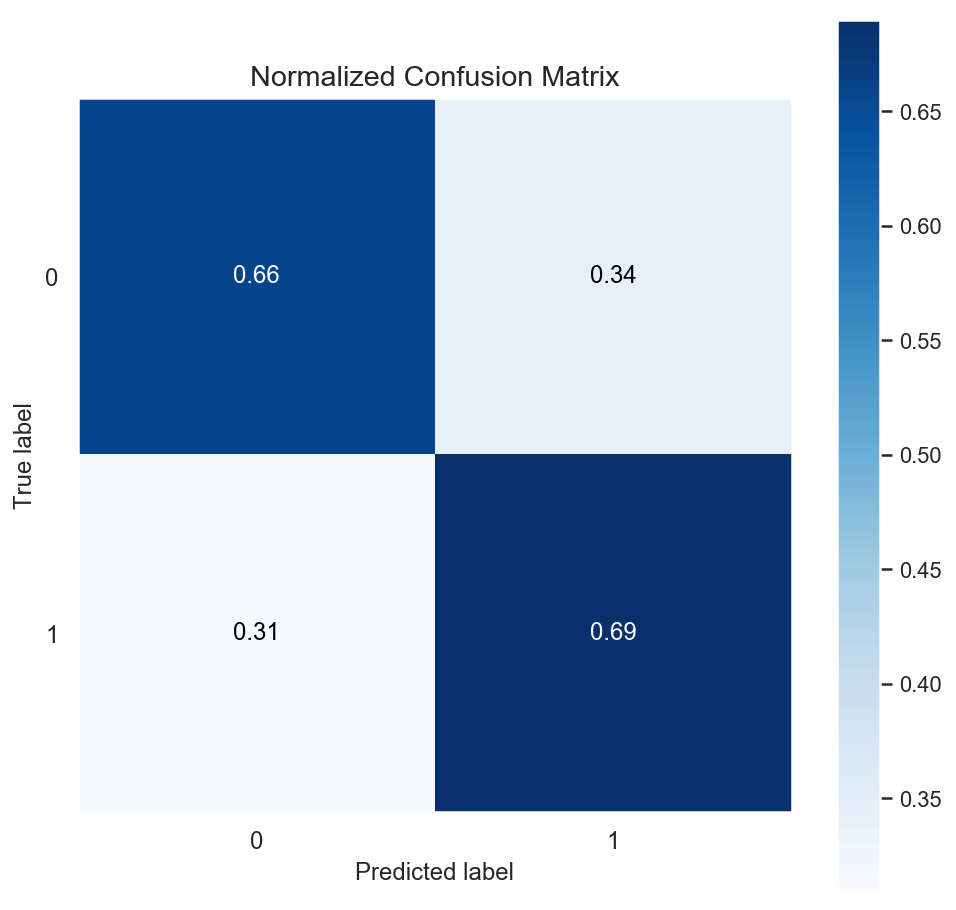

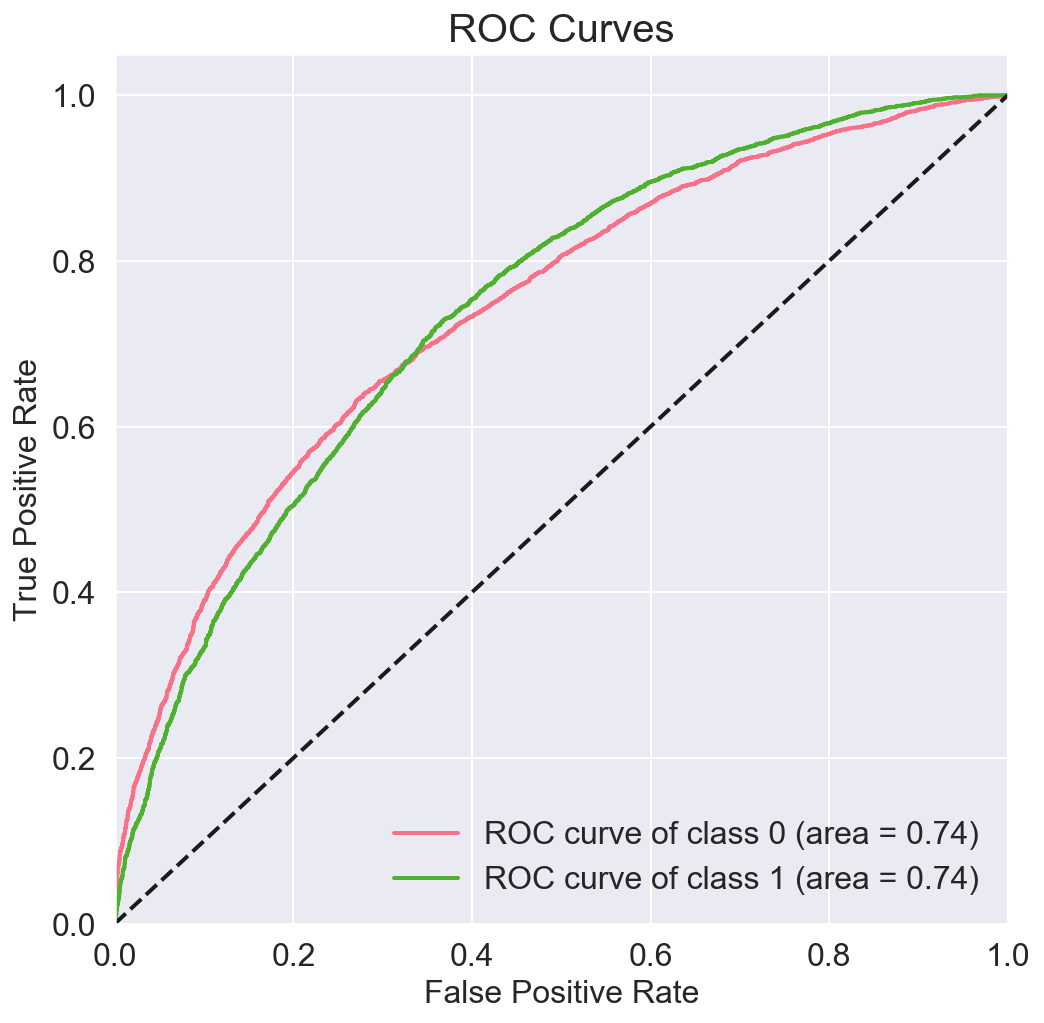

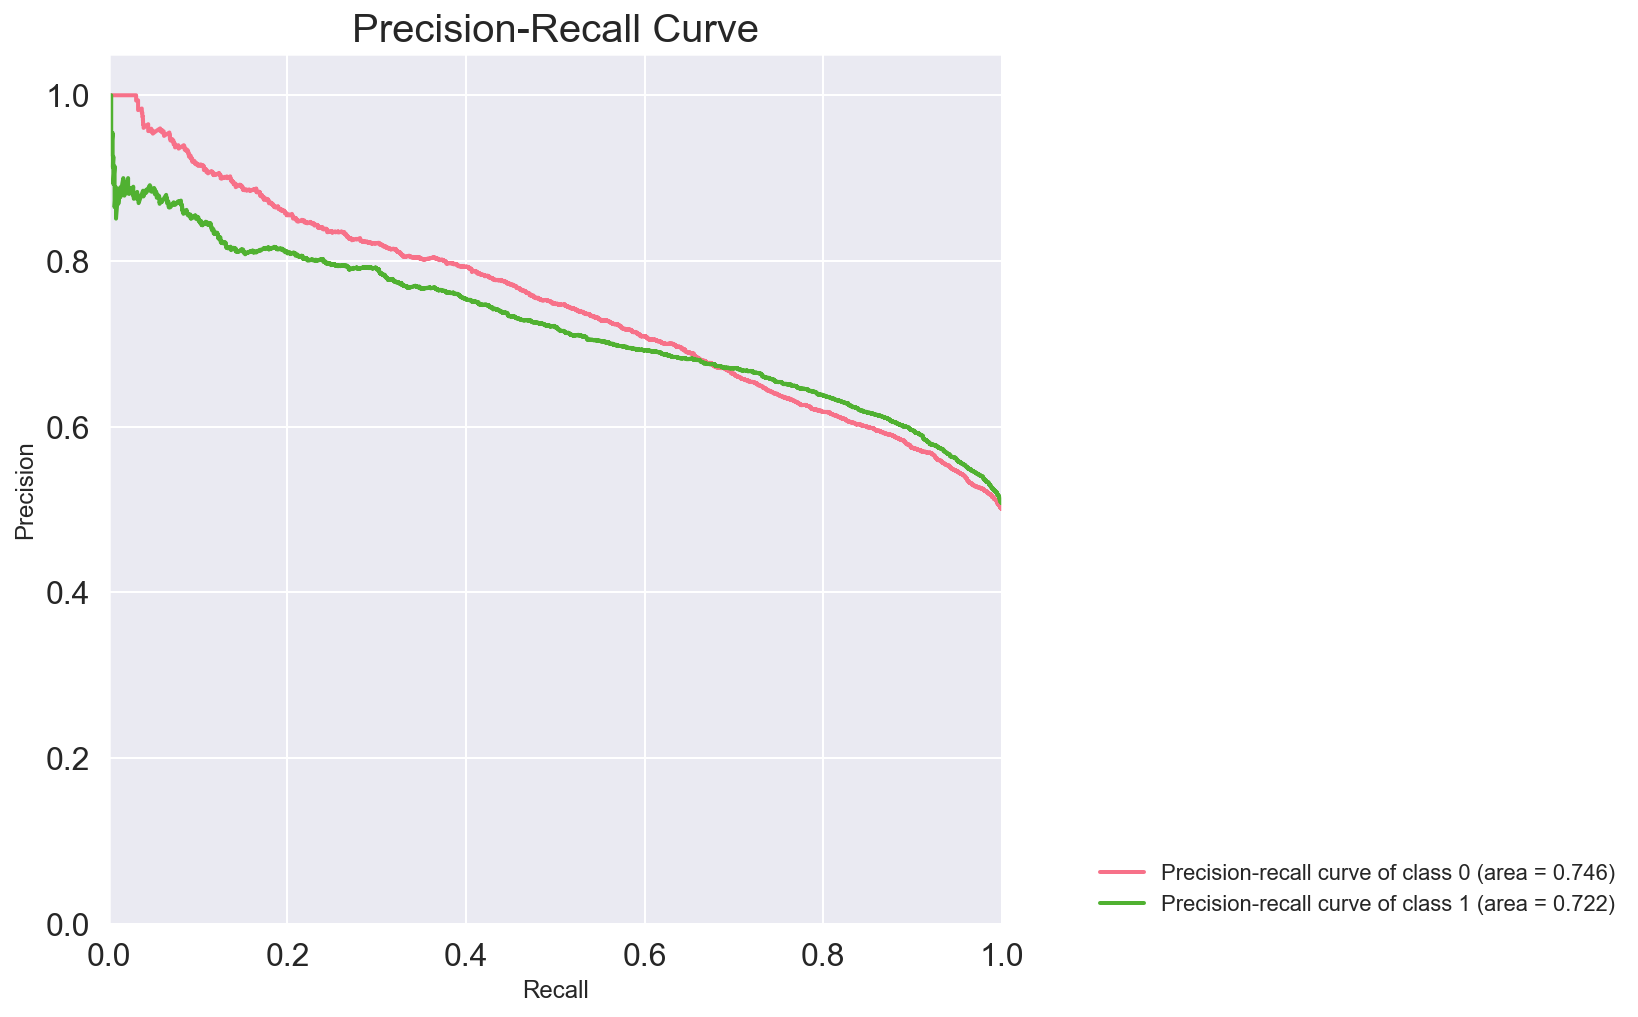

In [20]:
# matrix and graphs for the best model
model_class.matrix_n_graphs()

In [15]:
# Classification report
print(classification_report(model_class.y_test, model_class.y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.6832    0.6587    0.6707      5019
           1     0.6705    0.6945    0.6823      5018

    accuracy                         0.6766     10037
   macro avg     0.6768    0.6766    0.6765     10037
weighted avg     0.6768    0.6766    0.6765     10037



As can be seen here the classes are symmetrical and there is no large imbalance within the classification report. We are not able to move the threshold here as there we need to preserve the symmetry and moving the threshold would break the reversibility of the model.

## Coefficients

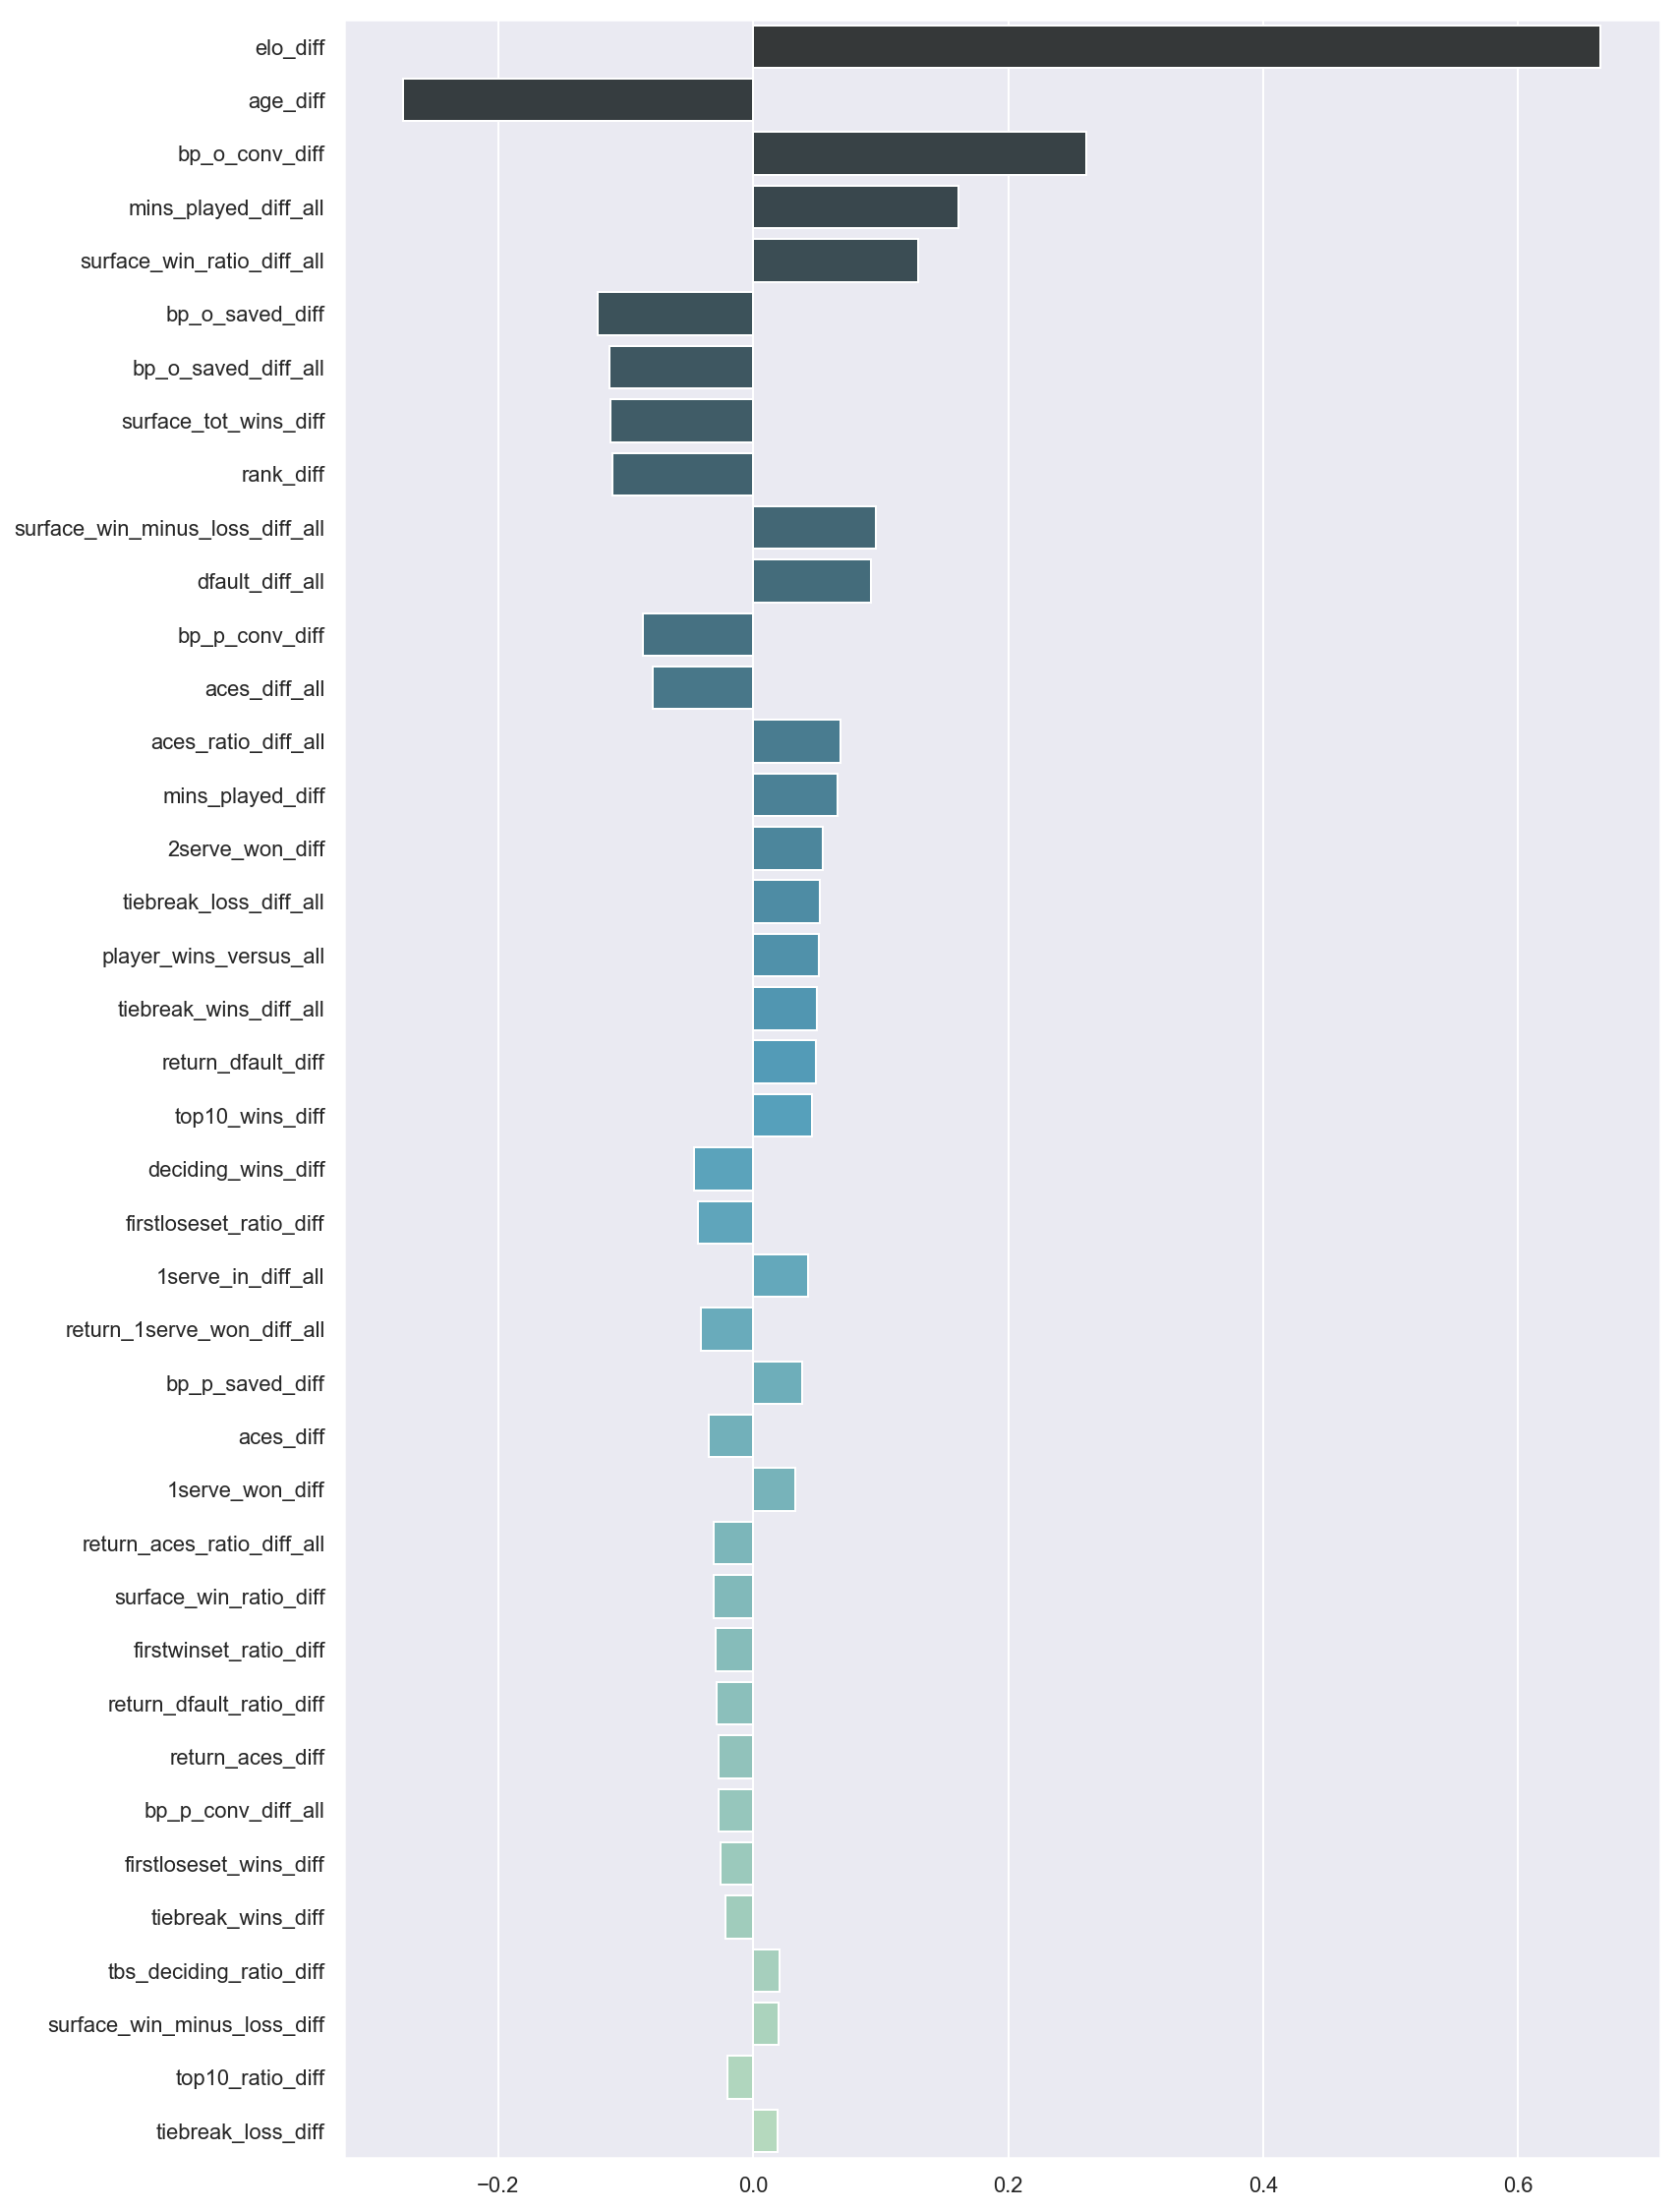

In [18]:
# sort coefs by abs desc order and plot
coeffs = model_class.coefs().T.iloc[(-model_class.coefs().T[0].abs()).argsort()].T.iloc[:,:40]

plt.figure(figsize=(12,20))
sns.set(font_scale=1)
sns.barplot(data=coeffs,orient="horizontal",palette="GnBu_d");

## Confidence Intervals - Frequentist Bootstraping

In [25]:
X['y']=y
# Null hypothesis - model is equivalent to predicting baseline
bootscv = []
bootstest = []
for i in range(1000):
    temp = X.sample(n=5000,replace=True)
    y_temp = temp.pop('y')
    # testing that the best model is symmetric
    X_flip = temp*-1
    y_flip = pd.Series(y_temp).map(lambda x: 0 if x==1 else 1)
    boot_class = full_classification(temp,y_temp,False,0.639,stratify=y_temp,print_info=False)
    boot_class.logistic_model()
    bootscv.append(boot_class.cvs)
    bootstest.append(boot_class.sct)
X.drop("y",axis=1,inplace=True)    

In [26]:
med_boot_lower = stats.scoreatpercentile(bootscv, 0.05)
med_boot_median = stats.scoreatpercentile(bootscv, 50)
med_boot_upper = stats.scoreatpercentile(bootscv, 99.95)
print(med_boot_lower, med_boot_median, med_boot_upper)
ttest = stats.ttest_1samp(bootscv, 0.639)
print('Single t_test pvalue of cvs versus baseline:',ttest.pvalue)

0.6429380483373575 0.6672873852193615 0.6870583158356773
Single t_test pvalue of cvs versus baseline: 0.0


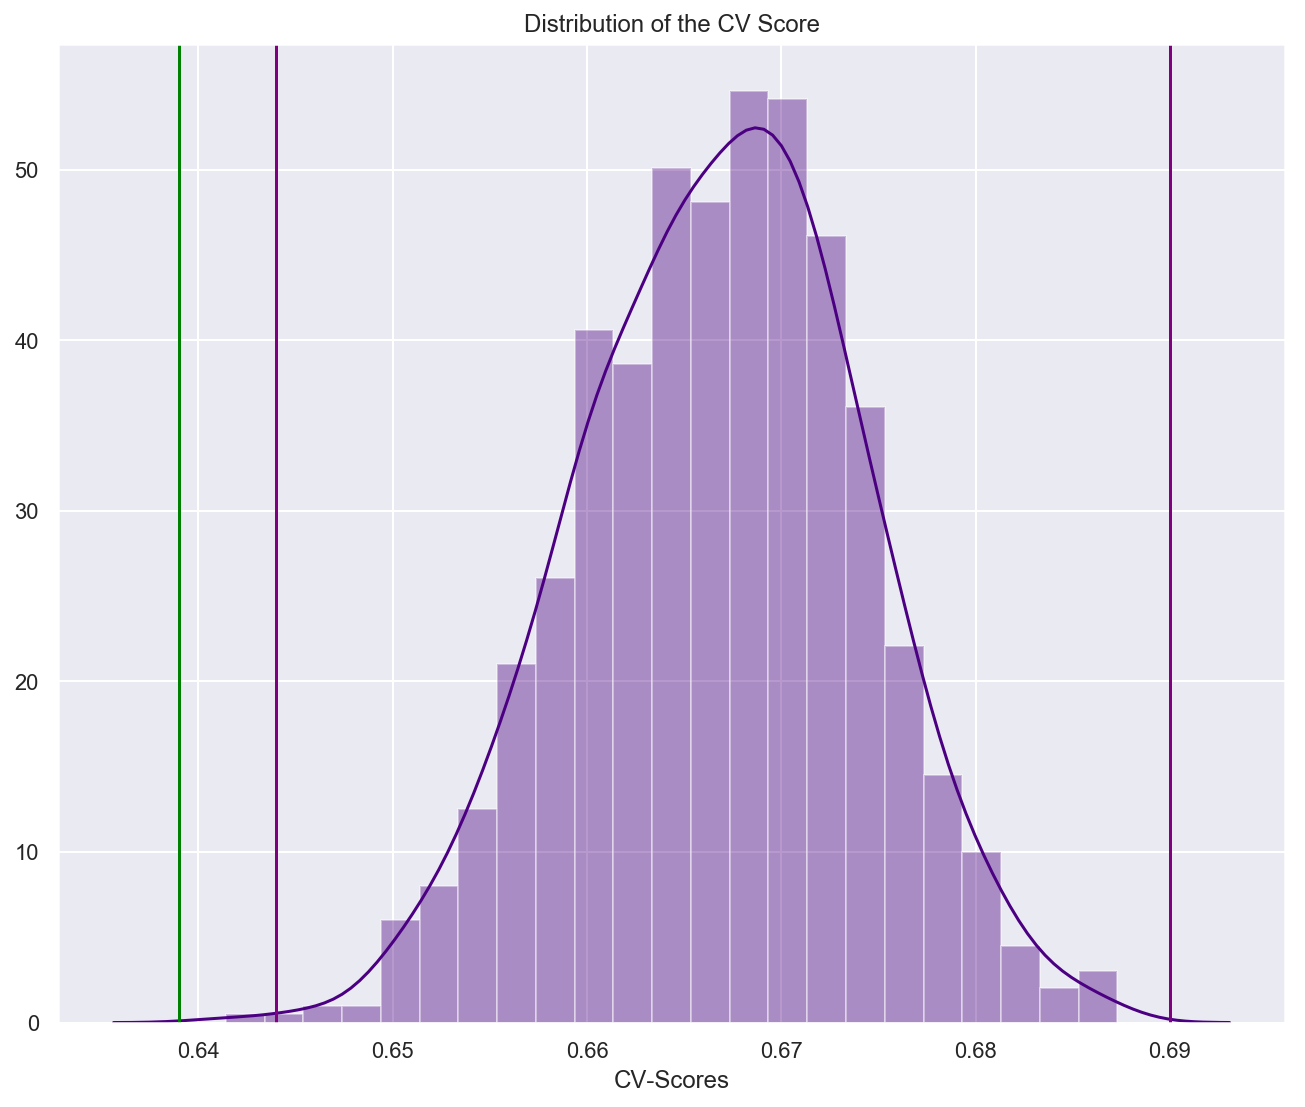

In [27]:
f, ax = plt.subplots(figsize=(11, 9))
sns.distplot(bootscv,color='indigo');
plt.axvline(0.639, 0,10,color='green');
plt.axvline(0.644, 0,10,color='purple');
plt.axvline(0.690, 0,10,color='purple');
ax.set_title('Distribution of the CV Score');
ax.set_xlabel('CV-Scores');

## Bayesian Model Testing

## Checking for Symmetry

In [28]:
# predictions from best model for test set
test_preds = pd.DataFrame(model_class.y_pred,index=model_class.index_test,columns=["Preds"])
# checking for perfect symmetry
(model_class.model.predict(model_class.Xf_test)+test_preds['Preds']).value_counts()


1    10037
Name: Preds, dtype: int64

If you add all predictions for each side together then the predictions all add up to one - meaning that the model does work completely symmetrically. This does not work for any of the other regular classification models. For example:

Decision Tree Model Test
Model Score: 0.6772 - better than baseline by 0.0382 
CV Fold Score: 0.6774 - better than baseline by 0.0384 
Model Test Score: 0.6734 - better than baseline by 0.0344
Flipped_Train =  0.5846
Flipped_Test =  0.5861
Time Elapsed =  7.39 secs - grid will take ~ 369.57 minutes to run.



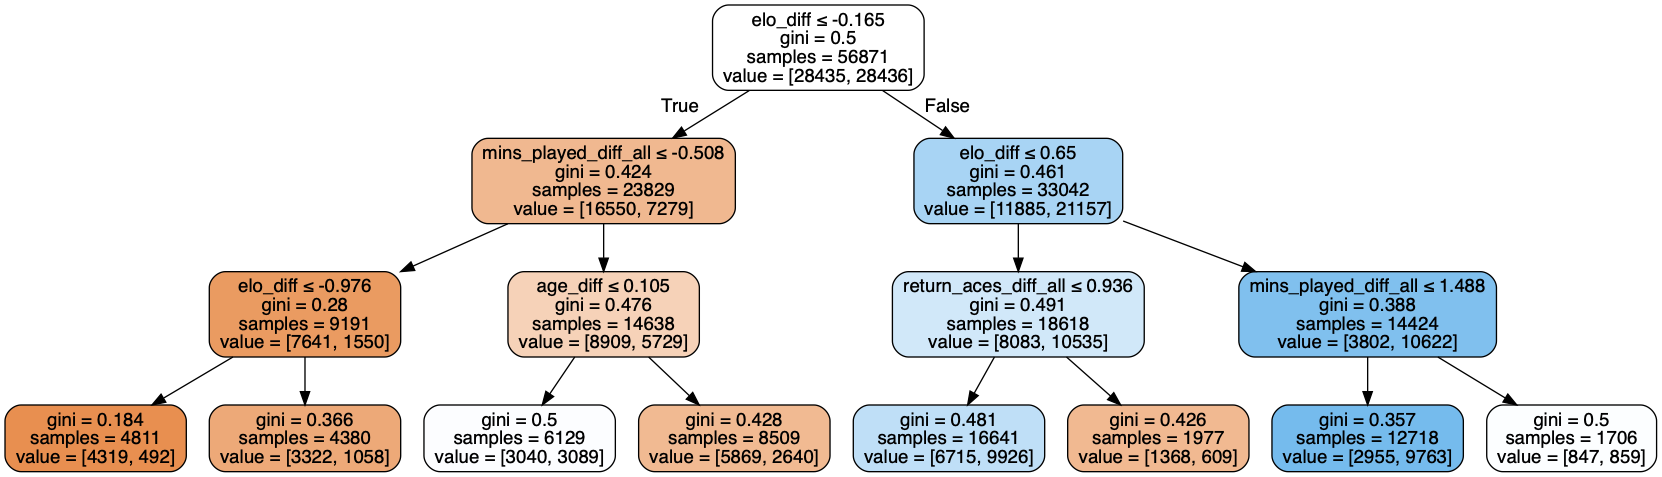

In [29]:
# Example showing that decision tree is not symmetric
# X.drop('y',axis=1,inplace=True)
X_flip = X*-1
y_flip = pd.Series(y).map(lambda x: 0 if x==1 else 1)
dec_tree_class = full_classification(X,y,False,0.639,stratify=y,standardize=True,shuffle=True,save_it=False)
dec_tree_class.decision_tree_model(True,DecisionTreeClassifier(max_depth=3))


In [30]:
# checking for perfect symmetry in decision tree model
pd.Series(dec_tree_class.model.predict(dec_tree_class.Xf_test)+
          dec_tree_class.model.predict(dec_tree_class.X_test)).value_counts()


1    6159
2    3424
0     454
dtype: int64

This shows that for half the time - the model will predict differently depending on which way you input the players and their stats. This makes sense as depending on the values you may end up going a different way down the decision tree.

## Probabilities and betting odds

In [15]:
# looking at the winning probabilities versus the betting odds
df_filt = pd.read_csv('filtered_all_symmetric.csv')
df_filt.columns

Index(['match_id', 'tournament_event_id', 'match_num', 'date', 'surface',
       'indoor', 'round', 'best_of', 'winner_id', 'winner_country_id',
       ...
       'Tournament', 'w_mean', 'l_mean', 'w_max', 'l_max', 'w_min', 'l_min',
       'w_mean_prob', 'l_mean_prob', 'mean_margin'],
      dtype='object', length=358)

In [21]:
# create the probability dataframes
train_probs = pd.DataFrame(model_class.model.predict_proba(model_class.X),index=model_class.index_train)
test_probs = pd.DataFrame(model_class.model.predict_proba(model_class.X_test),index=model_class.index_test)
train_probs['pred'], test_probs['pred'] = model_class.model.predict(model_class.X), model_class.y_pred
train_probs['y_act'], test_probs['y_act'] = model_class.y, model_class.y_test
train_probs["pred_correct"] = (train_probs.pred-train_probs.y_act).map(lambda x: 0 if x in [1,-1] else 1)
test_probs["pred_correct"] = (test_probs.pred-test_probs.y_act).map(lambda x: 0 if x in [1,-1] else 1) 
train_probs['model_winner_prob'] = [train_probs.iloc[i,value] for i, value in enumerate(train_probs.y_act)]
test_probs['model_winner_prob'] = [test_probs.iloc[i,value] for i, value in enumerate(test_probs.y_act)]
df_probs = pd.concat([train_probs,test_probs])

# check test set
test_probs_df = pd.merge(test_probs,df_filt[['w_mean', 'l_mean', 'w_max', 'l_max', 'w_min', 'l_min',
       'w_mean_prob', 'l_mean_prob', 'mean_margin','winner_rank','loser_rank']],how='left',left_index=True,right_index=True)
test_probs_df.dropna(inplace=True)
test_probs_df["diff_from_bookies"] = test_probs_df.model_winner_prob - test_probs_df.w_mean_prob

# merge with actual odds
df_probs = pd.merge(df_filt[['w_mean', 'l_mean', 'w_max', 'l_max', 'w_min', 'l_min',
       'w_mean_prob', 'l_mean_prob', 'mean_margin','winner_rank','loser_rank']],df_probs,how='left',left_index=True,right_index=True)
df_probs.dropna(inplace=True)
df_probs["diff_from_bookies"] = df_probs.model_winner_prob - df_probs.w_mean_prob

In [22]:
df_probs

,w_mean,l_mean,w_max,l_max,w_min,l_min,w_mean_prob,l_mean_prob,mean_margin,winner_rank,loser_rank,0,1,pred,y_act,pred_correct,model_winner_prob,diff_from_bookies
2940,2.200,1.615,2.200,1.615,2.200,1.615,0.454545,0.619195,-0.073741,71.0,43.0,0.572764,0.427236,0,1,0,0.427236,-0.027309
2941,1.571,2.250,1.571,2.250,1.571,2.250,0.636537,0.444444,-0.080982,18.0,50.0,0.374489,0.625511,1,1,1,0.625511,-0.011026
2942,2.625,1.444,2.625,1.444,2.625,1.444,0.380952,0.692521,-0.073473,56.0,17.0,0.588902,0.411098,0,1,0,0.411098,0.030146
2943,1.222,4.000,1.222,4.000,1.222,4.000,0.818331,0.250000,-0.068331,21.0,95.0,0.210653,0.789347,1,1,1,0.789347,-0.028983
2944,1.533,2.375,1.533,2.375,1.533,2.375,0.652316,0.421053,-0.073368,31.0,159.0,0.310645,0.689355,1,1,1,0.689355,0.037040
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66852,1.415,3.005,1.440,3.260,1.390,2.750,0.706714,0.332779,-0.039492,1.0,6.0,0.713918,0.286082,0,0,1,0.713918,0.007204
66853,2.115,1.760,2.130,1.800,2.100,1.720,0.472813,0.568182,-0.040995,1.0,4.0,0.645846,0.354154,0,0,1,0.645846,0.173033
66854,1.820,2.050,1.840,2.100,1.800,2.000,0.549451,0.487805,-0.037255,5.0,7.0,0.464002,0.535998,1,0,0,0.464002,-0.085449
66855,3.625,1.315,3.750,1.330,3.500,1.300,0.275862,0.760456,-0.036318,6.0,3.0,0.304915,0.695085,1,0,0,0.304915,0.029053


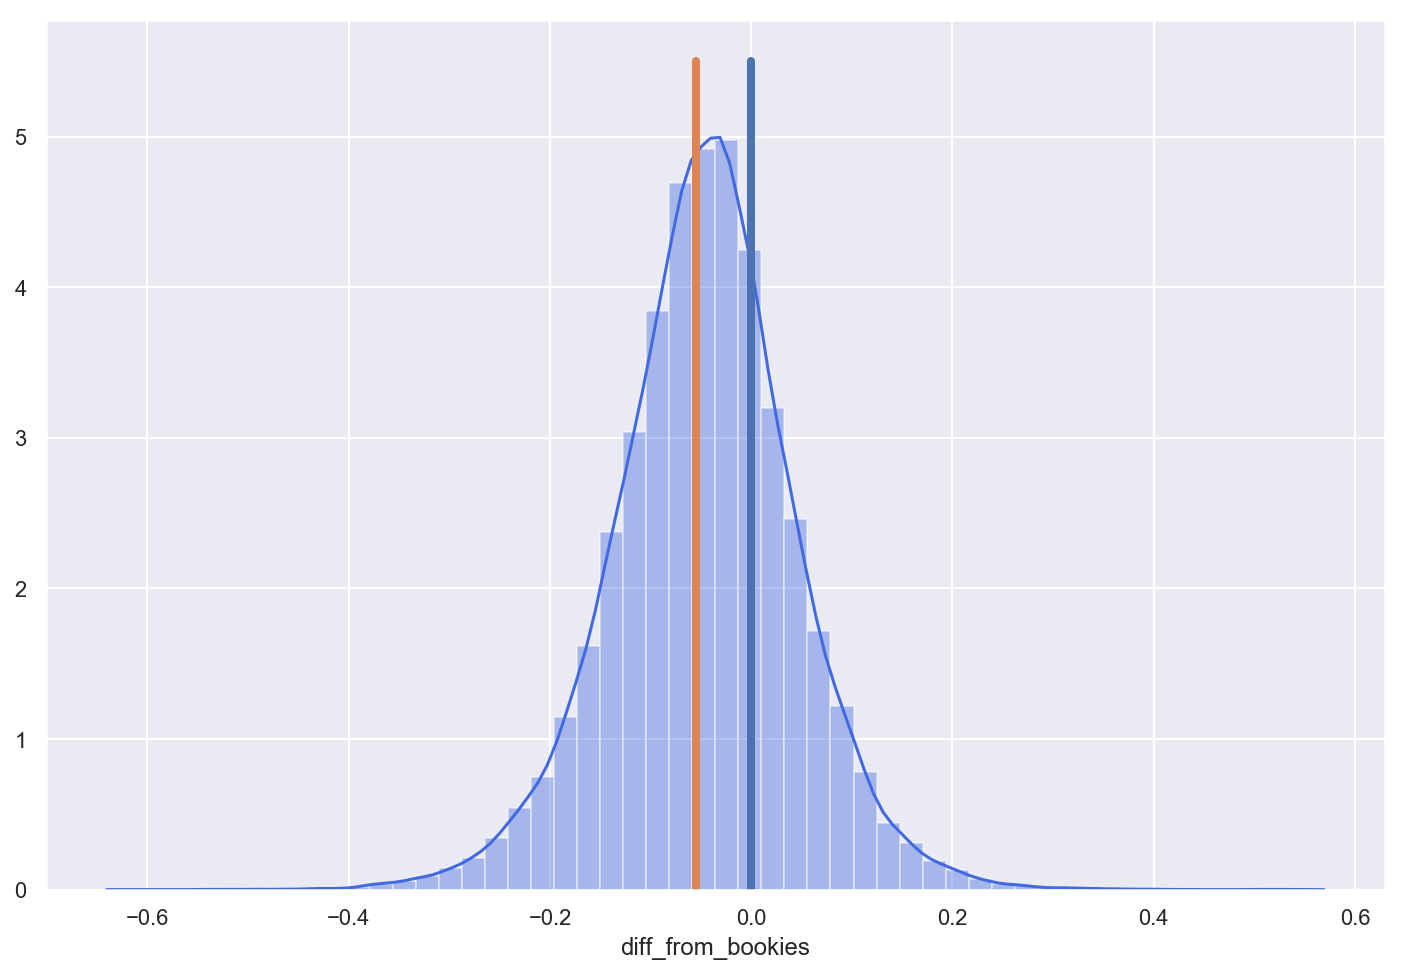

In [23]:
# difference from bookies in %
plt.figure(figsize=(12,8))
sns.distplot(df_probs["diff_from_bookies"],color="royalblue");
plt.plot([0,0],[0,5.5],lw=4);
plt.plot([-0.055,-0.055],[0,5.5],lw=4);

In [24]:
# ON TEST SET
# ROI for baseline
bet_amount=10
test_probs_df['baseline_ROI'] = ((test_probs_df['winner_rank']-test_probs_df['loser_rank']).map(
    lambda x: 1 if x < 0 else 0)*test_probs_df.w_max*bet_amount)-bet_amount
ROI_b = round(np.sum(test_probs_df['baseline_ROI'])/(len(test_probs_df['baseline_ROI'])*bet_amount),3)*100
print("If you bet systematically based on the best ranked player - ROI=",ROI_b,"%")

# ROI for random betting
from random import randint
ROI_r_lst = []
for num in range(1,1000):
    test_probs_df['random_ROI'] = test_probs_df['baseline_ROI'].apply(lambda x: randint(0,1))*test_probs_df.w_max*bet_amount-bet_amount
    ROI_r = np.sum(test_probs_df['random_ROI'])/(len(test_probs_df['random_ROI'])*bet_amount)*100
    ROI_r_lst.append(ROI_r)
print("If you bet randomly - ROI=",round(np.mean(ROI_r_lst),3),"%")

# ROI for odds favorite
test_probs_df['lowest_odds_ROI'] = ((test_probs_df['w_max']-test_probs_df['l_max']).map(
    lambda x: 0 if x > 0 else 1)*test_probs_df.w_max*bet_amount)-bet_amount
ROI_l = round(np.sum(test_probs_df['lowest_odds_ROI'])/(len(test_probs_df['lowest_odds_ROI'])*bet_amount),3)*100
print("If you bet systematically on the player with the lowest odds - ROI=",ROI_l,"%")


If you bet systematically based on the best ranked player - ROI= -2.1 %
If you bet randomly - ROI= -4.415 %
If you bet systematically on the player with the lowest odds - ROI= -0.5 %


In [25]:
# ON ALL
# ROI for baseline
bet_amount=10
df_probs['baseline_ROI'] = ((df_probs['winner_rank']-df_probs['loser_rank']).map(
    lambda x: 1 if x < 0 else 0)*df_probs.w_max*bet_amount)-bet_amount
ROI_b = round(np.sum(df_probs['baseline_ROI'])/(len(df_probs['baseline_ROI'])*bet_amount),3)*100
print("If you bet systematically based on the best ranked player - ROI=",ROI_b,"%")

# ROI for random betting
from random import randint
ROI_r_lst = []
for num in range(1,1000):
    df_probs['random_ROI'] = df_probs['baseline_ROI'].apply(lambda x: randint(0,1))*df_probs.w_max*bet_amount-bet_amount
    ROI_r = np.sum(df_probs['random_ROI'])/(len(df_probs['random_ROI'])*bet_amount)*100
    ROI_r_lst.append(ROI_r)
print("If you bet randomly - ROI=",round(np.mean(ROI_r_lst),3),"%")

# ROI for odds favorite
df_probs['lowest_odds_ROI'] = ((df_probs['w_max']-df_probs['l_max']).map(
    lambda x: 0 if x > 0 else 1)*df_probs.w_max*bet_amount)-bet_amount
ROI_l = round(np.sum(df_probs['lowest_odds_ROI'])/(len(df_probs['lowest_odds_ROI'])*bet_amount),3)*100
print("If you bet systematically on the player with the lowest odds - ROI=",ROI_l,"%")

If you bet systematically based on the best ranked player - ROI= -2.6 %
If you bet randomly - ROI= -4.013 %
If you bet systematically on the player with the lowest odds - ROI= -0.8 %


In [26]:
df_probs.iloc[:,2:]

,w_max,l_max,w_min,l_min,w_mean_prob,l_mean_prob,mean_margin,winner_rank,loser_rank,0,1,pred,y_act,pred_correct,model_winner_prob,diff_from_bookies,baseline_ROI,random_ROI,lowest_odds_ROI
2940,2.200,1.615,2.200,1.615,0.454545,0.619195,-0.073741,71.0,43.0,0.572764,0.427236,0,1,0,0.427236,-0.027309,-10.00,12.00,-10.00
2941,1.571,2.250,1.571,2.250,0.636537,0.444444,-0.080982,18.0,50.0,0.374489,0.625511,1,1,1,0.625511,-0.011026,5.71,-10.00,5.71
2942,2.625,1.444,2.625,1.444,0.380952,0.692521,-0.073473,56.0,17.0,0.588902,0.411098,0,1,0,0.411098,0.030146,-10.00,16.25,-10.00
2943,1.222,4.000,1.222,4.000,0.818331,0.250000,-0.068331,21.0,95.0,0.210653,0.789347,1,1,1,0.789347,-0.028983,2.22,-10.00,2.22
2944,1.533,2.375,1.533,2.375,0.652316,0.421053,-0.073368,31.0,159.0,0.310645,0.689355,1,1,1,0.689355,0.037040,5.33,-10.00,5.33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66852,1.440,3.260,1.390,2.750,0.706714,0.332779,-0.039492,1.0,6.0,0.713918,0.286082,0,0,1,0.713918,0.007204,4.40,-10.00,4.40
66853,2.130,1.800,2.100,1.720,0.472813,0.568182,-0.040995,1.0,4.0,0.645846,0.354154,0,0,1,0.645846,0.173033,11.30,11.30,-10.00
66854,1.840,2.100,1.800,2.000,0.549451,0.487805,-0.037255,5.0,7.0,0.464002,0.535998,1,0,0,0.464002,-0.085449,8.40,-10.00,8.40
66855,3.750,1.330,3.500,1.300,0.275862,0.760456,-0.036318,6.0,3.0,0.304915,0.695085,1,0,0,0.304915,0.029053,-10.00,27.50,-10.00


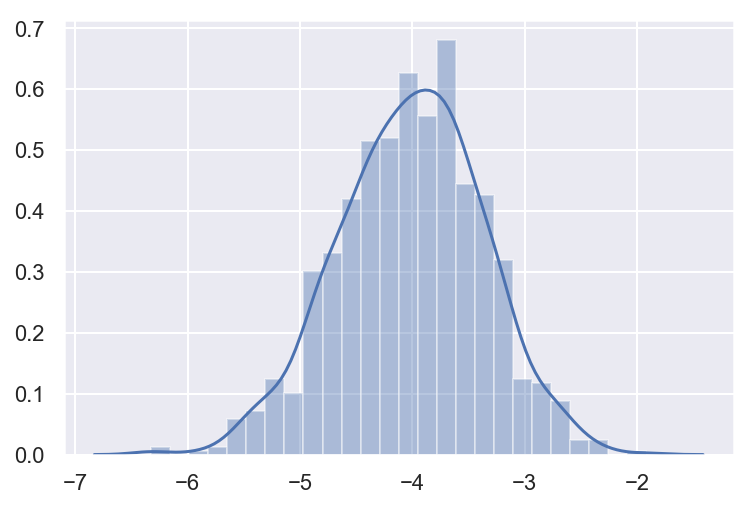

In [27]:
sns.distplot(ROI_r_lst);

In [54]:
# ROI calc for the test set
bet_amount = 10
test_probs_df['ROI_max'] = (test_probs_df.pred_correct*test_probs_df.w_max*bet_amount)-bet_amount
# test_probs_df['ROI_min'] = (test_probs_df.pred_correct*test_probs_df.w_min*bet_amount)-bet_amount
# ROI_min = round(np.sum(test_probs_df['ROI_min'])/(len(test_probs_df['ROI_min'])*bet_amount),3)*100
ROI_max = round(np.sum(test_probs_df['ROI_max'])/(len(test_probs_df['ROI_max'])*bet_amount),3)*100

test_probs_df['ROI_60_conf'] = test_probs_df.ROI_max[(test_probs_df[0]>0.60)|(test_probs_df[1]>0.60)] 
test_probs_df.ROI_60_conf.fillna(0,inplace=True)
ROI_60_confident = np.sum(test_probs_df.ROI_60_conf)/(len(test_probs_df[test_probs_df.ROI_60_conf!=0])*bet_amount)

test_probs_df['ROI_75_conf'] = test_probs_df.ROI_max[(test_probs_df[0]>0.75)|(test_probs_df[1]>0.75)] 
test_probs_df.ROI_75_conf.fillna(0,inplace=True)
ROI_75_confident = np.sum(test_probs_df.ROI_75_conf)/(len(test_probs_df[test_probs_df.ROI_75_conf!=0])*bet_amount)

test_probs_df['ROI_90_conf'] = test_probs_df.ROI_max[(test_probs_df[0]>0.90)|(test_probs_df[1]>0.90)] 
test_probs_df.ROI_90_conf.fillna(0,inplace=True)
ROI_90_confident = np.sum(test_probs_df.ROI_90_conf)/(len(test_probs_df[test_probs_df.ROI_90_conf!=0])*bet_amount)

test_probs_df["blend"] = test_probs_df[0].map(lambda x: ((x-0.5)/0.5) if x>0.500 else ((0.5-x)/0.5))
test_probs_df["blend_inv"] = test_probs_df.blend*10
test_probs_df['blend_ROI'] = test_probs_df['ROI_max']*test_probs_df.blend
blend_ROI = np.sum(test_probs_df['blend_ROI'])/np.sum(test_probs_df["blend_inv"])
# print("The min return on investment for this model would be:",ROI_min,"%")
print("The max return on investment for this model would be:",ROI_max,"%")
print("At best you would have placed",len(test_probs_df['ROI_max'])*bet_amount,"in bets and made",
      ROI_max/100*len(test_probs_df['ROI_max'])*bet_amount,"profit!")




The max return on investment for this model would be: -3.3000000000000003 %
At best you would have placed 47980 in bets and made -1583.3400000000001 profit!


In [44]:
# np.sum(test_probs_df.ROI_60_conf)
# len(test_probs_df[test_probs_df.ROI_60_conf!=0])

In [55]:
blend_ROI

-0.02447497907406385

In [58]:
df_cols = pd.DataFrame(data = [-4.61,-2.7,-0.8,0,-3.31,-3.2,0.37,0.3,-2.4],index = 
                       ["Betting Randomly","Highest Rank", "Tightest Odds", 
                        "Not Betting",'Model - Every Match',"Model - 60% confidence",
                        "Model - 75% confidence","Model - 90% confidence","Model - Blended"],
                       columns = ["Returns"])


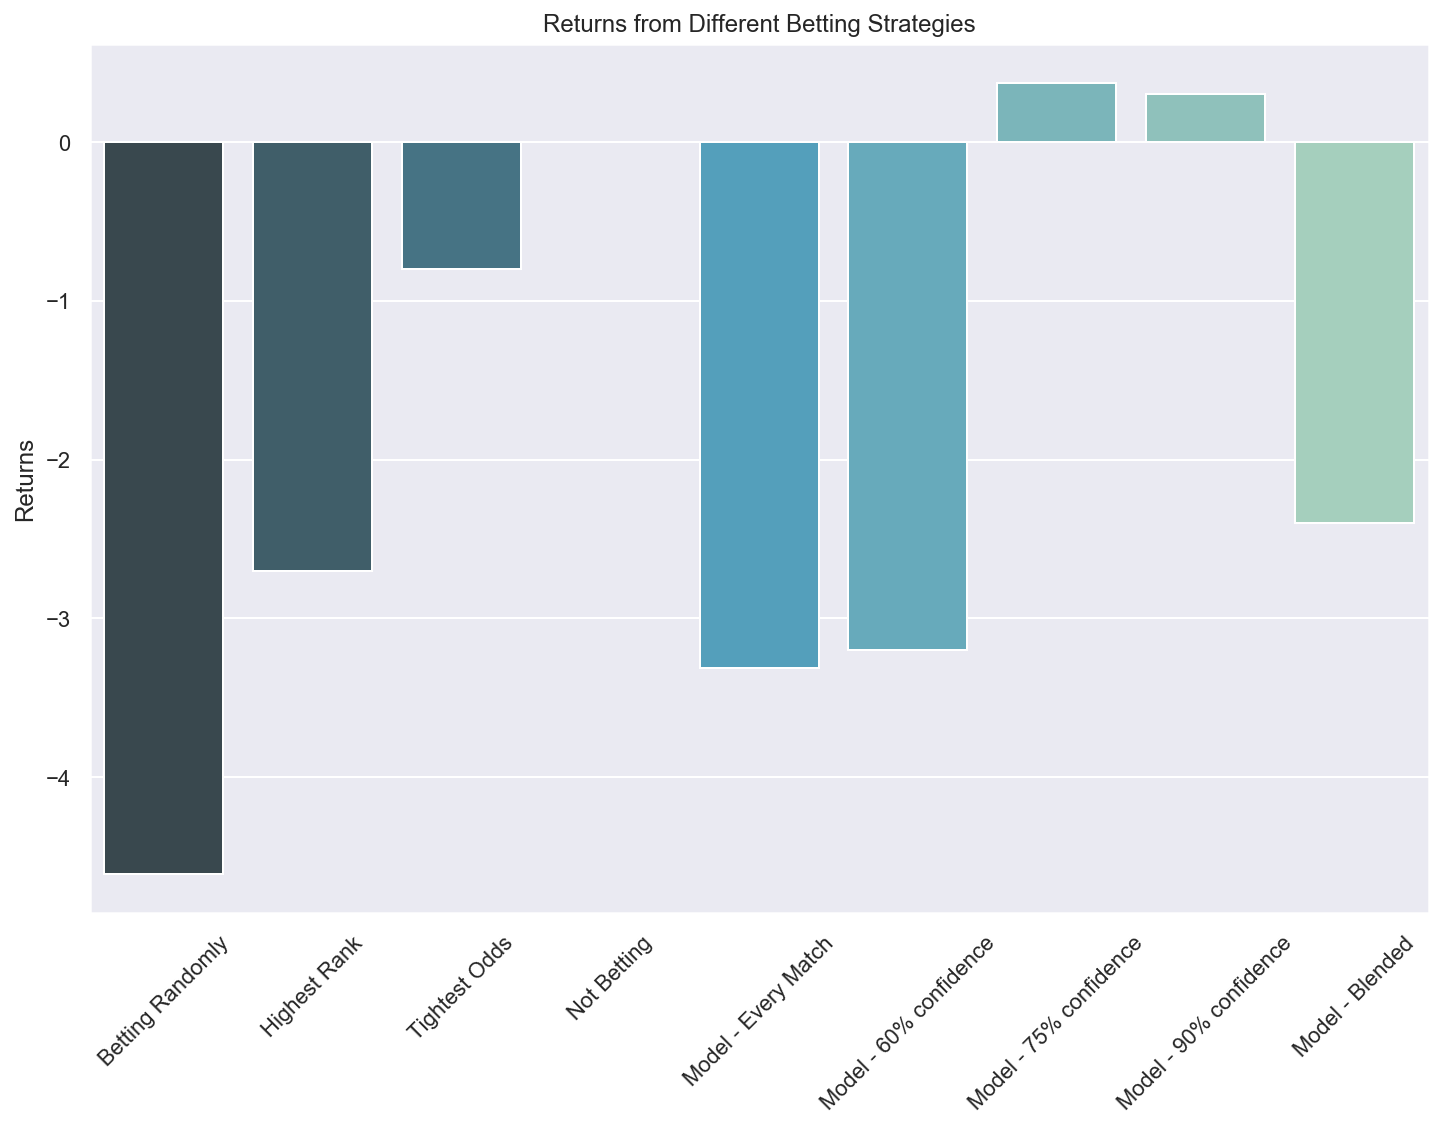

In [93]:
f, ax = plt.subplots(figsize=(12,8))
sns.barplot(x=df_cols.index,y=df_cols["Returns"],palette="GnBu_d")
ax.set_title('Returns from Different Betting Strategies');
ax.set_xticklabels(ax.get_xticklabels(), rotation=45);

In [37]:
# % correct for matches with odds in test set
test_probs_df.pred_correct.value_counts(normalize=True)

1    0.666945
0    0.333055
Name: pred_correct, dtype: float64

In [38]:
odds_check = test_probs_df.w_mean_prob-test_probs_df.l_mean_prob
print("In this test set - the bookies favorite wins:",round(len(odds_check[odds_check>=0])/len(odds_check),3),"% of the time")
print("Mean margin for betmaker for test set =",round(np.mean(test_probs_df['mean_margin']),3))


In this test set - the bookies favorite wins: 0.694 % of the time
Mean margin for betmaker for test set = -0.055


In [72]:
# ROI calc for all data with odds
bet_amount = 10
df_probs['ROI_max'] = (df_probs.pred_correct*df_probs.w_max*bet_amount)-bet_amount
# df_probs['ROI_min'] = (df_probs.pred_correct*df_probs.w_min*bet_amount)-bet_amount
# ROI_min = round(np.sum(df_probs['ROI_min'])/(len(df_probs['ROI_min'])*bet_amount),3)*100
ROI_max = round(np.sum(df_probs['ROI_max'])/(len(df_probs['ROI_max'])*bet_amount),3)*100

print("The min return on investment for this model would be:",ROI_min,"%")
print("The max return on investment for this model would be:",round(ROI_max,0),"%")
print("At best you would have placed",len(df_probs['ROI_max'])*bet_amount,"in bets and made",
      round(ROI_max/100*len(df_probs['ROI_max']),2)*bet_amount,"profit!")

The min return on investment for this model would be: -7.3999999999999995 %
The max return on investment for this model would be: -4.0 %
At best you would have placed 317860 in bets and made -12396.5 profit!


In [40]:
# % correct for matches with odds in test set
print(df_probs.pred_correct.value_counts(normalize=True))
print(df_probs.pred_correct.value_counts())


1    0.663594
0    0.336406
Name: pred_correct, dtype: float64
1    21093
0    10693
Name: pred_correct, dtype: int64


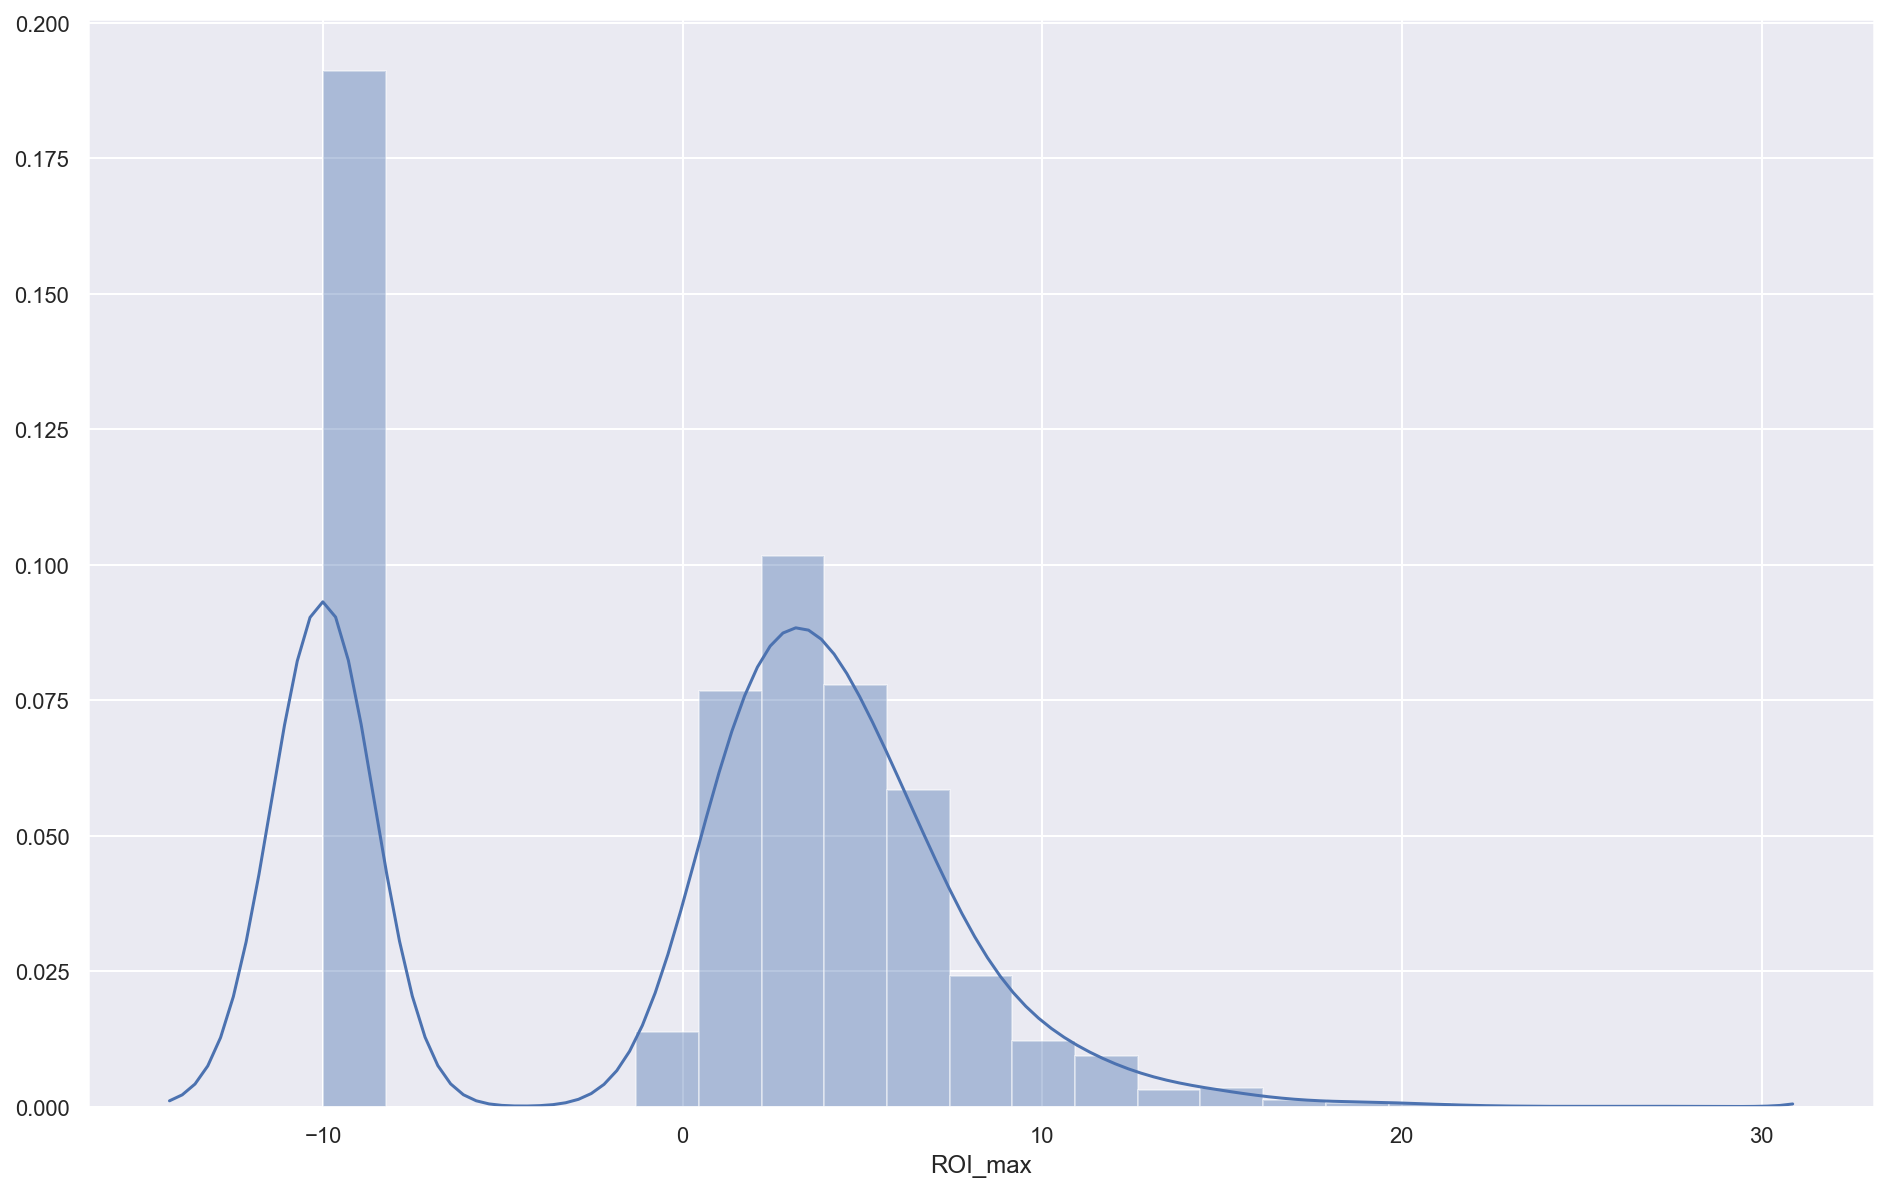

In [41]:
plt.figure(figsize=(16,10))
sns.distplot(test_probs_df.ROI_max);
ax.set_title('ROI Distribution for Model');

## PCA

In [41]:
from sklearn.decomposition import PCA

In [42]:
# g = sns.PairGrid(X, height=4)
# g = g.map_lower(sns.regplot)    # regression plots in lower tri
# g = g.map_upper(sns.kdeplot, cmap="Blues", shade=True,
#                 shade_lowest=False)  # KDE plots in upper tri
# g = g.map_diag(plt.hist)        # histograms along diagonal

# plt.show()

In [43]:
# PCA without changing directionality

scaler = StandardScaler()
Xs = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
PCA_n = 60
pca = PCA(PCA_n)
pca.fit(Xs)

PCA_dict = {'PC'+str(i+1): pca.components_[i]
            for i in range(len(pca.components_))}

rankdf = pd.DataFrame(PCA_dict, index=Xs.columns)

In [44]:
df_pca = pca.transform(Xs)
df_pca= pd.DataFrame(df_pca,columns=['PC'+str(i+1)
                                for i in range(PCA_n)],
                       index=Xs.index)
df_pca['win'] = y

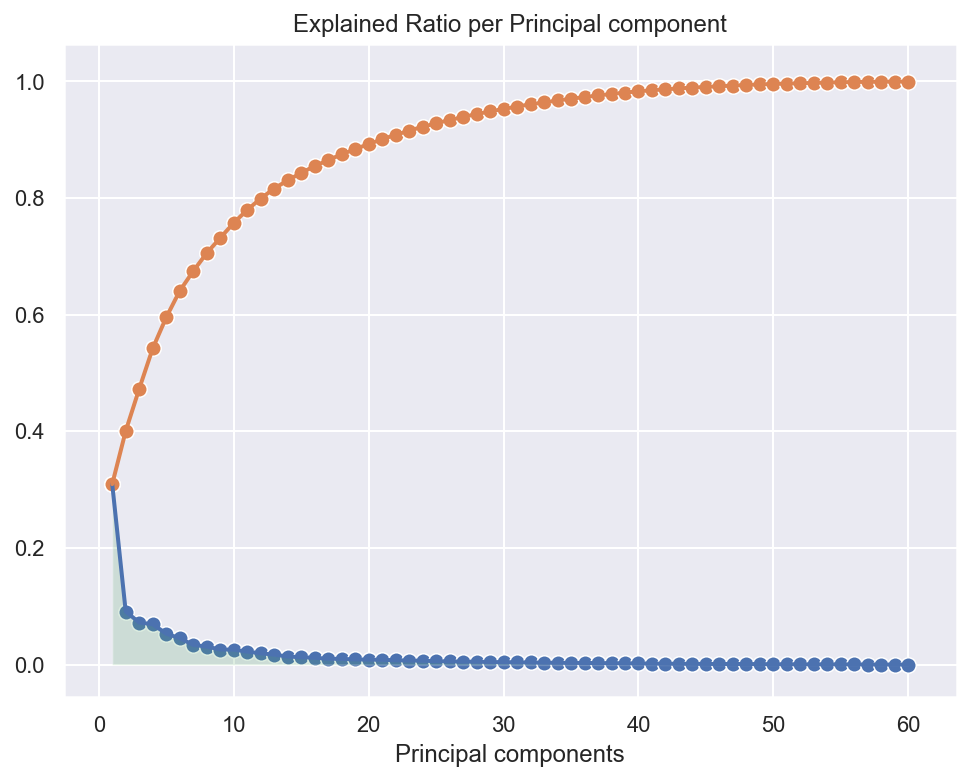

In [45]:
exp_var = pca.explained_variance_ratio_

fig, ax = plt.subplots(figsize=(8,6))
x_values = list(range(1, pca.n_components_+1))
sns.lineplot(x_values, exp_var, lw=2);
sns.scatterplot(x_values, exp_var, s=60);
sns.lineplot(x_values, np.cumsum(exp_var), lw=2);
sns.scatterplot(x_values, np.cumsum(exp_var), s=60);
plt.fill_between(x_values, exp_var,0,alpha=0.2)
ax.set_title('Explained Ratio per Principal component');
ax.set_xlabel('Principal components');



In [46]:
print(round(exp_var[0]*100,1),"% of the data is explained by PC1")

31.0 % of the data is explained by PC1


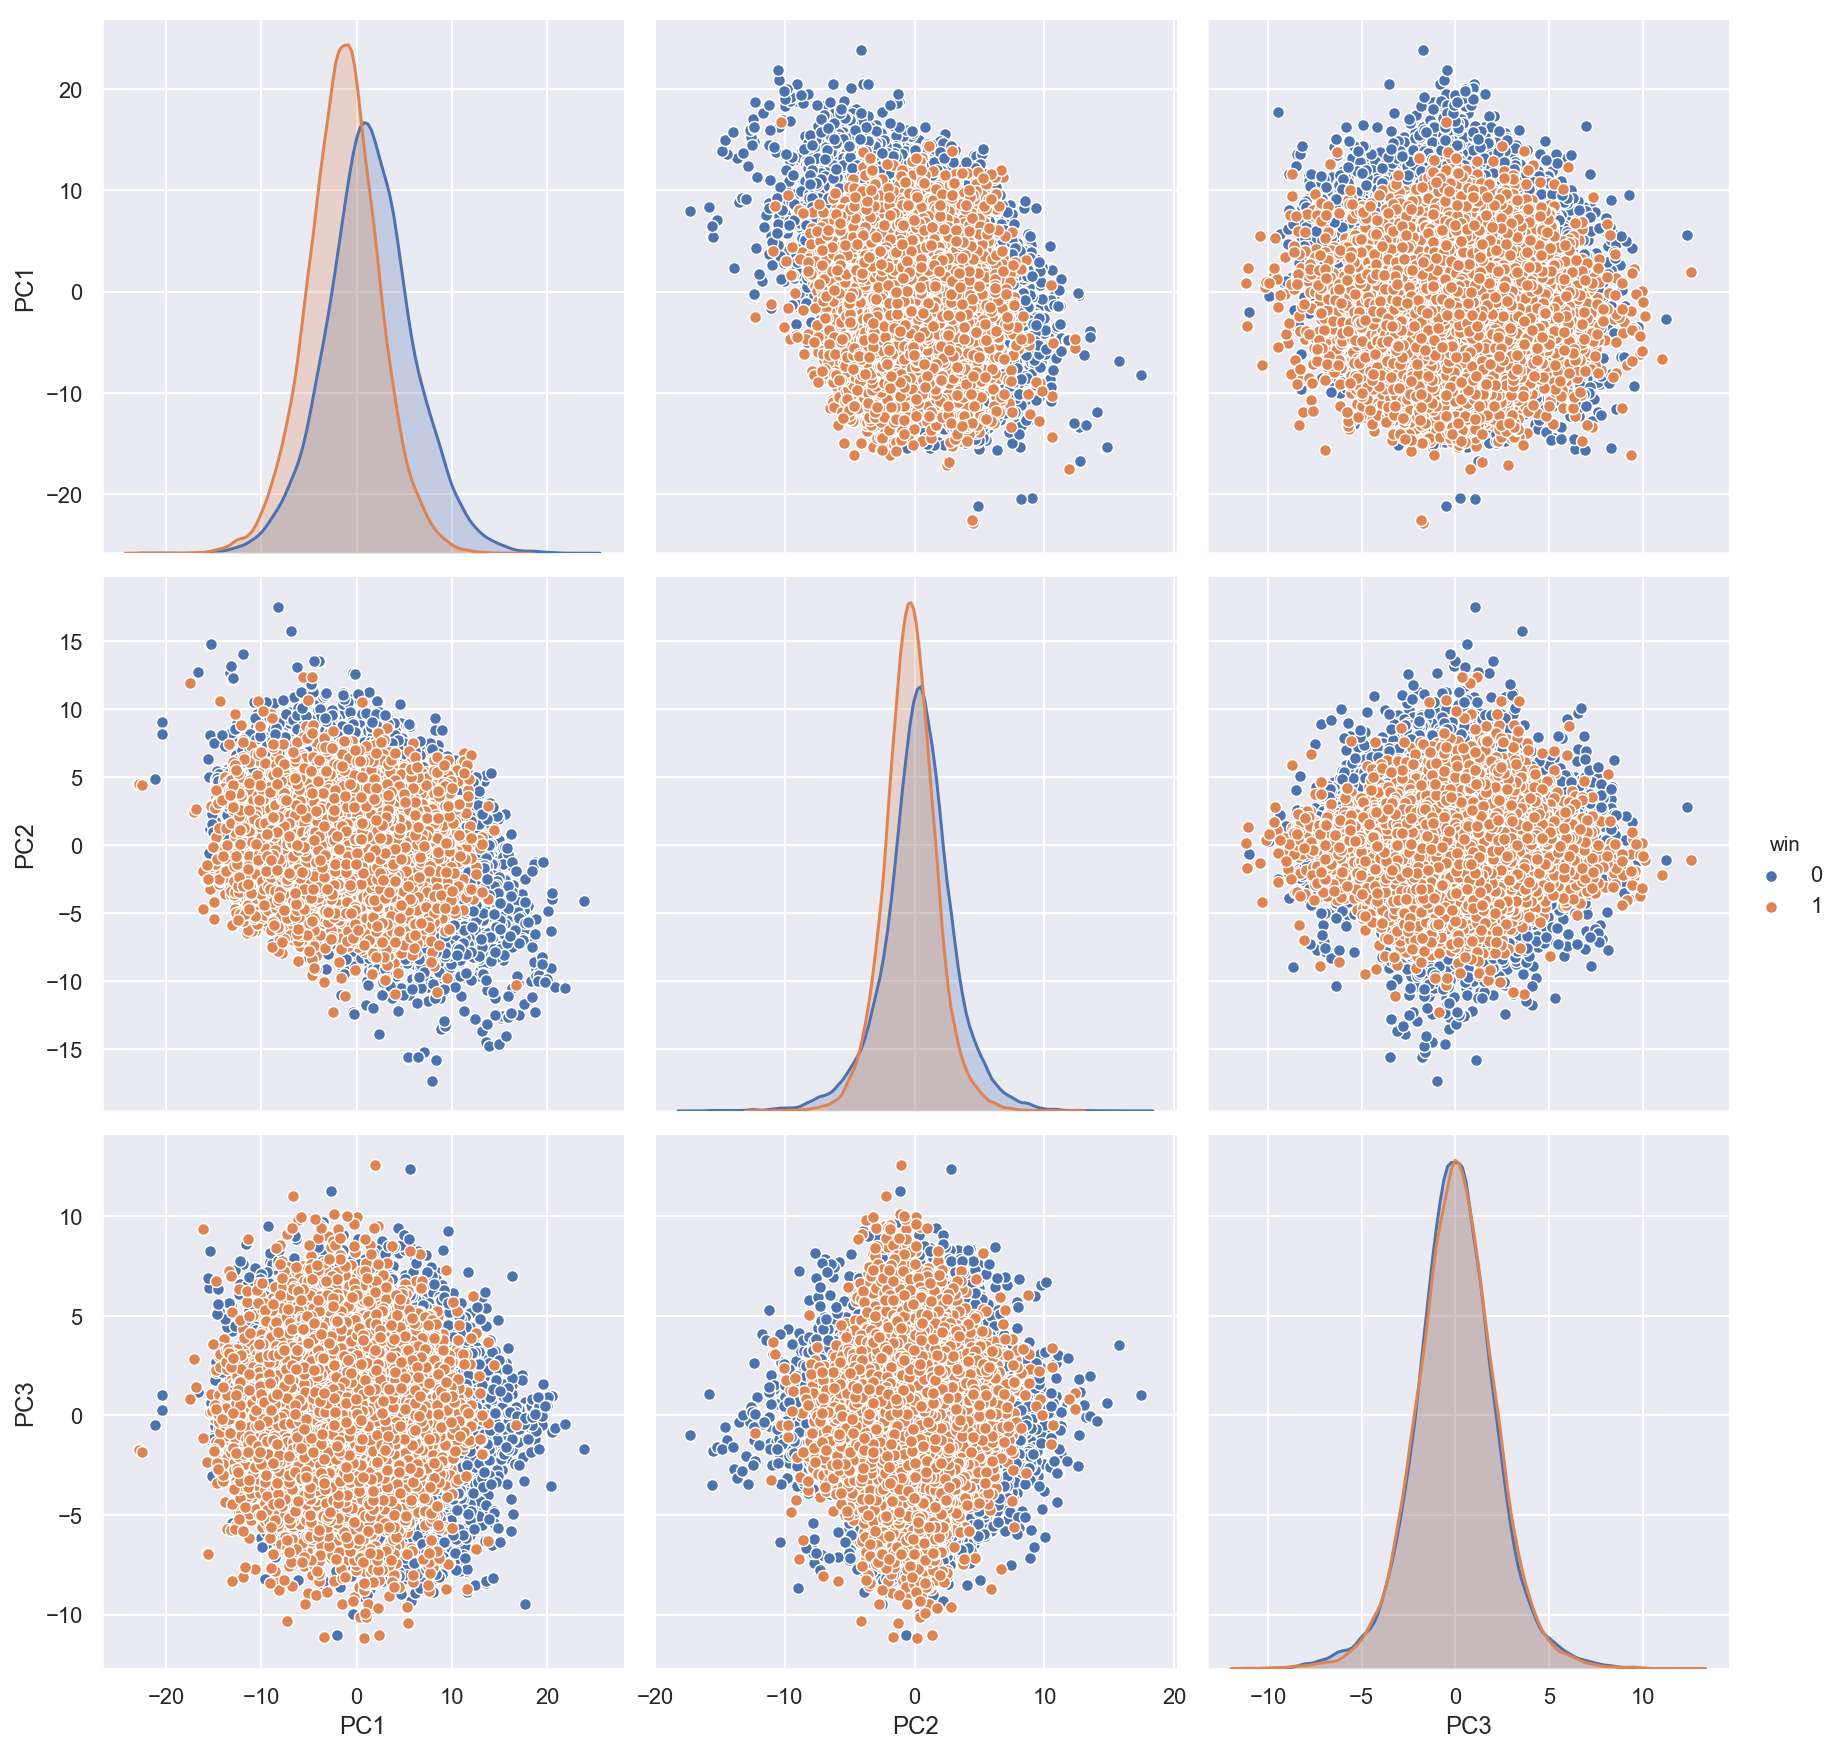

In [47]:
# first 3 PCAs split by win/loss
sns.pairplot(data=df_pca, vars=['PC1', 'PC2', 'PC3'], 
             hue='win', height=4)
plt.show()

In [48]:
# Reruning model on only PC levels to see impact
fullpca = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10',
       'PC11', 'PC12', 'PC13', 'PC14', 'PC15', 'PC16', 'PC17', 'PC18', 'PC19',
       'PC20', 'PC21', 'PC22', 'PC23', 'PC24', 'PC25', 'PC26', 'PC27', 'PC28',
       'PC29', 'PC30', 'PC31', 'PC32', 'PC33', 'PC34', 'PC35', 'PC36', 'PC37',
       'PC38', 'PC39', 'PC40', 'PC41', 'PC42', 'PC43', 'PC44', 'PC45', 'PC46',
       'PC47', 'PC48', 'PC49', 'PC50', 'PC51', 'PC52', 'PC53', 'PC54', 'PC55',
       'PC56', 'PC57', 'PC58', 'PC59', 'PC60']
pclist = []
scorelst = []
for pc in fullpca:
    pclist.append(pc)
    X_flip = df_pca[pclist]*-1
    y_flip = pd.Series(y).map(lambda x: 0 if x==1 else 1)
    PCA_model = full_classification(df_pca[pclist],y,False,0.639,stratify=y,standardize=True,shuffle=True,print_info=False)
    PCA_model.logistic_model()
    scorelst.append(PCA_model.cvs)

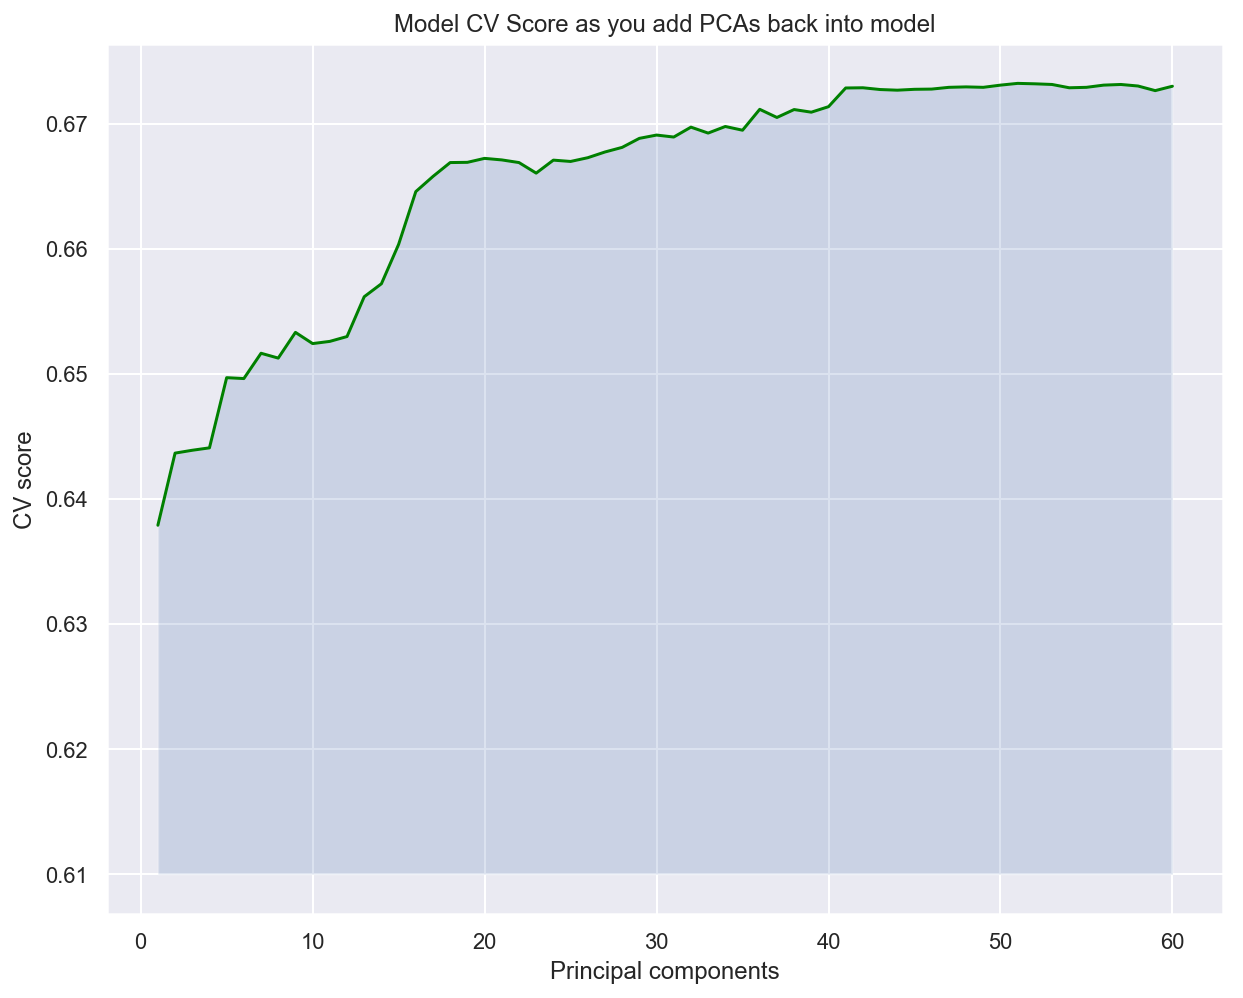

In [49]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.lineplot(x=range(1,61),y=scorelst,color='green');
plt.fill_between(range(1,61), scorelst,0.61,alpha=0.2)
ax.set_title('Model CV Score as you add PCAs back into model');
ax.set_xlabel('Principal components');
ax.set_ylabel('CV score');
    

## Model tracking

In [100]:
model_tracker['predictors_count'] = model_tracker['predictors'].apply(lambda x: len(x.split(',')))


In [99]:
model_tracker = pd.read_csv('model_tracker_backup.csv')

In [101]:
model_tracker.model_type = model_tracker.model_type.apply(lambda x: "ADABoosting Model" if x == "Boosting Model" else x)

In [102]:
model_tracker.head(2)

,Usable,baseline,comment,cv_above_baseline,cv_score,info,model_params,model_train_score,model_type,predictors,test_score,time,predictors_count
0,False,0.64,first model using only ranking,-0.043591,0.596409,first go of models with all the incorrect data,"KNeighborsClassifier(algorithm='auto', leaf_si...",0.599588,K Neighbors Model,rank_diff,0.592311,4.757046,1
1,False,0.64,first model using only ranking,0.005570,0.645570,first go of models with all the incorrect data,"DecisionTreeClassifier(ccp_alpha=0.0, class_we...",0.657202,Decision Tree Model,rank_diff,0.648216,0.533561,1


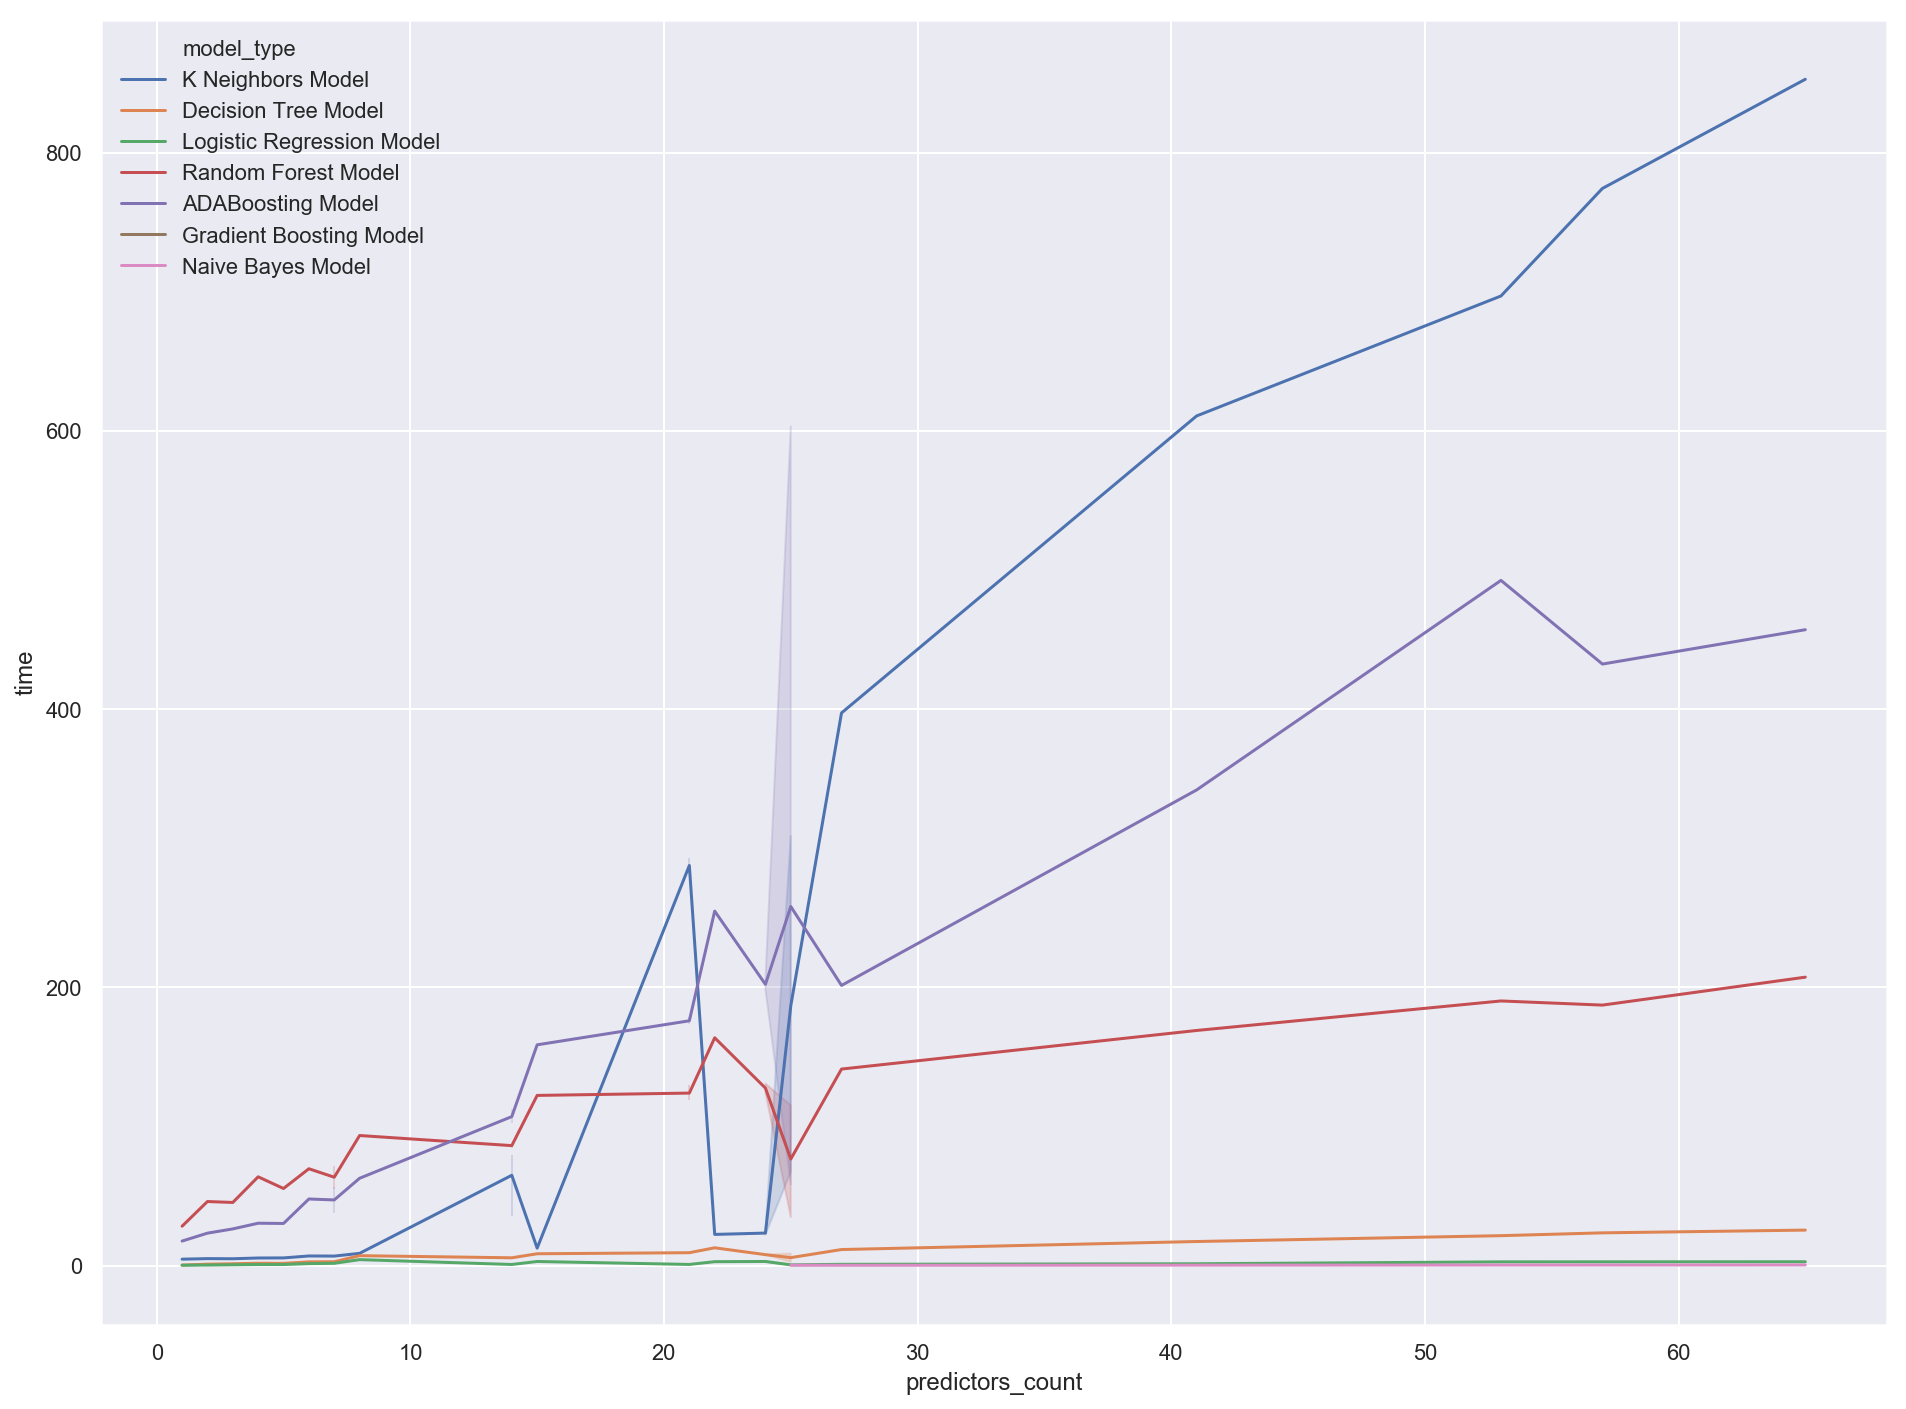

In [103]:
plt.figure(figsize=(16,12))
sns.lineplot(x=model_tracker.predictors_count[model_tracker['model_type']!="Gradient Boosting Model"],y=model_tracker.time,hue=model_tracker.model_type);

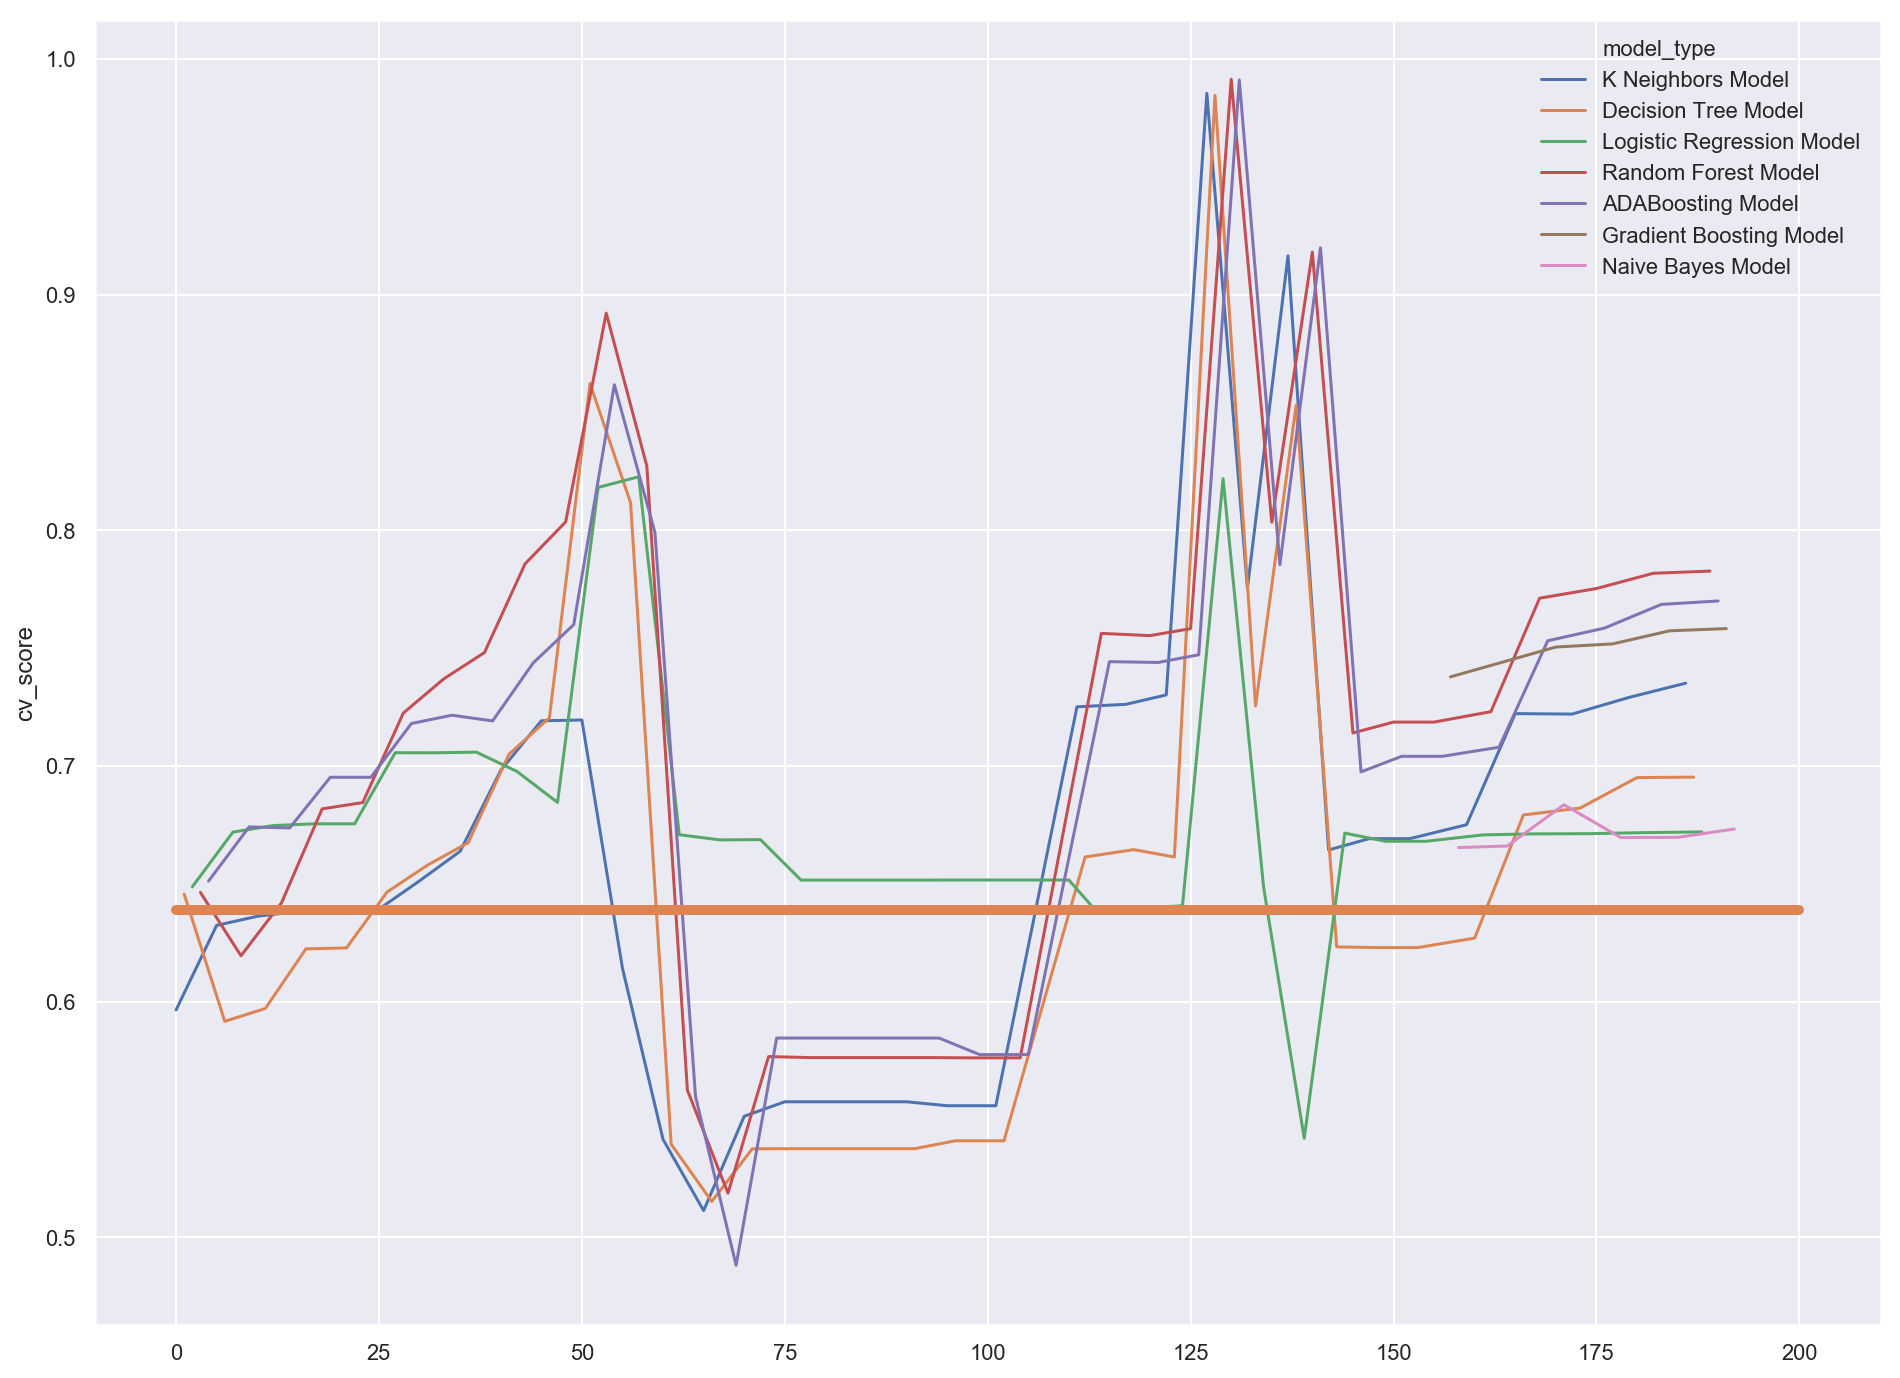

In [104]:
plt.figure(figsize=(16,12))
sns.lineplot(x=model_tracker.index,y=model_tracker.cv_score,hue=model_tracker.model_type);
sns.lineplot(x=(0,200),y=(0.639,0.639),lw=5);

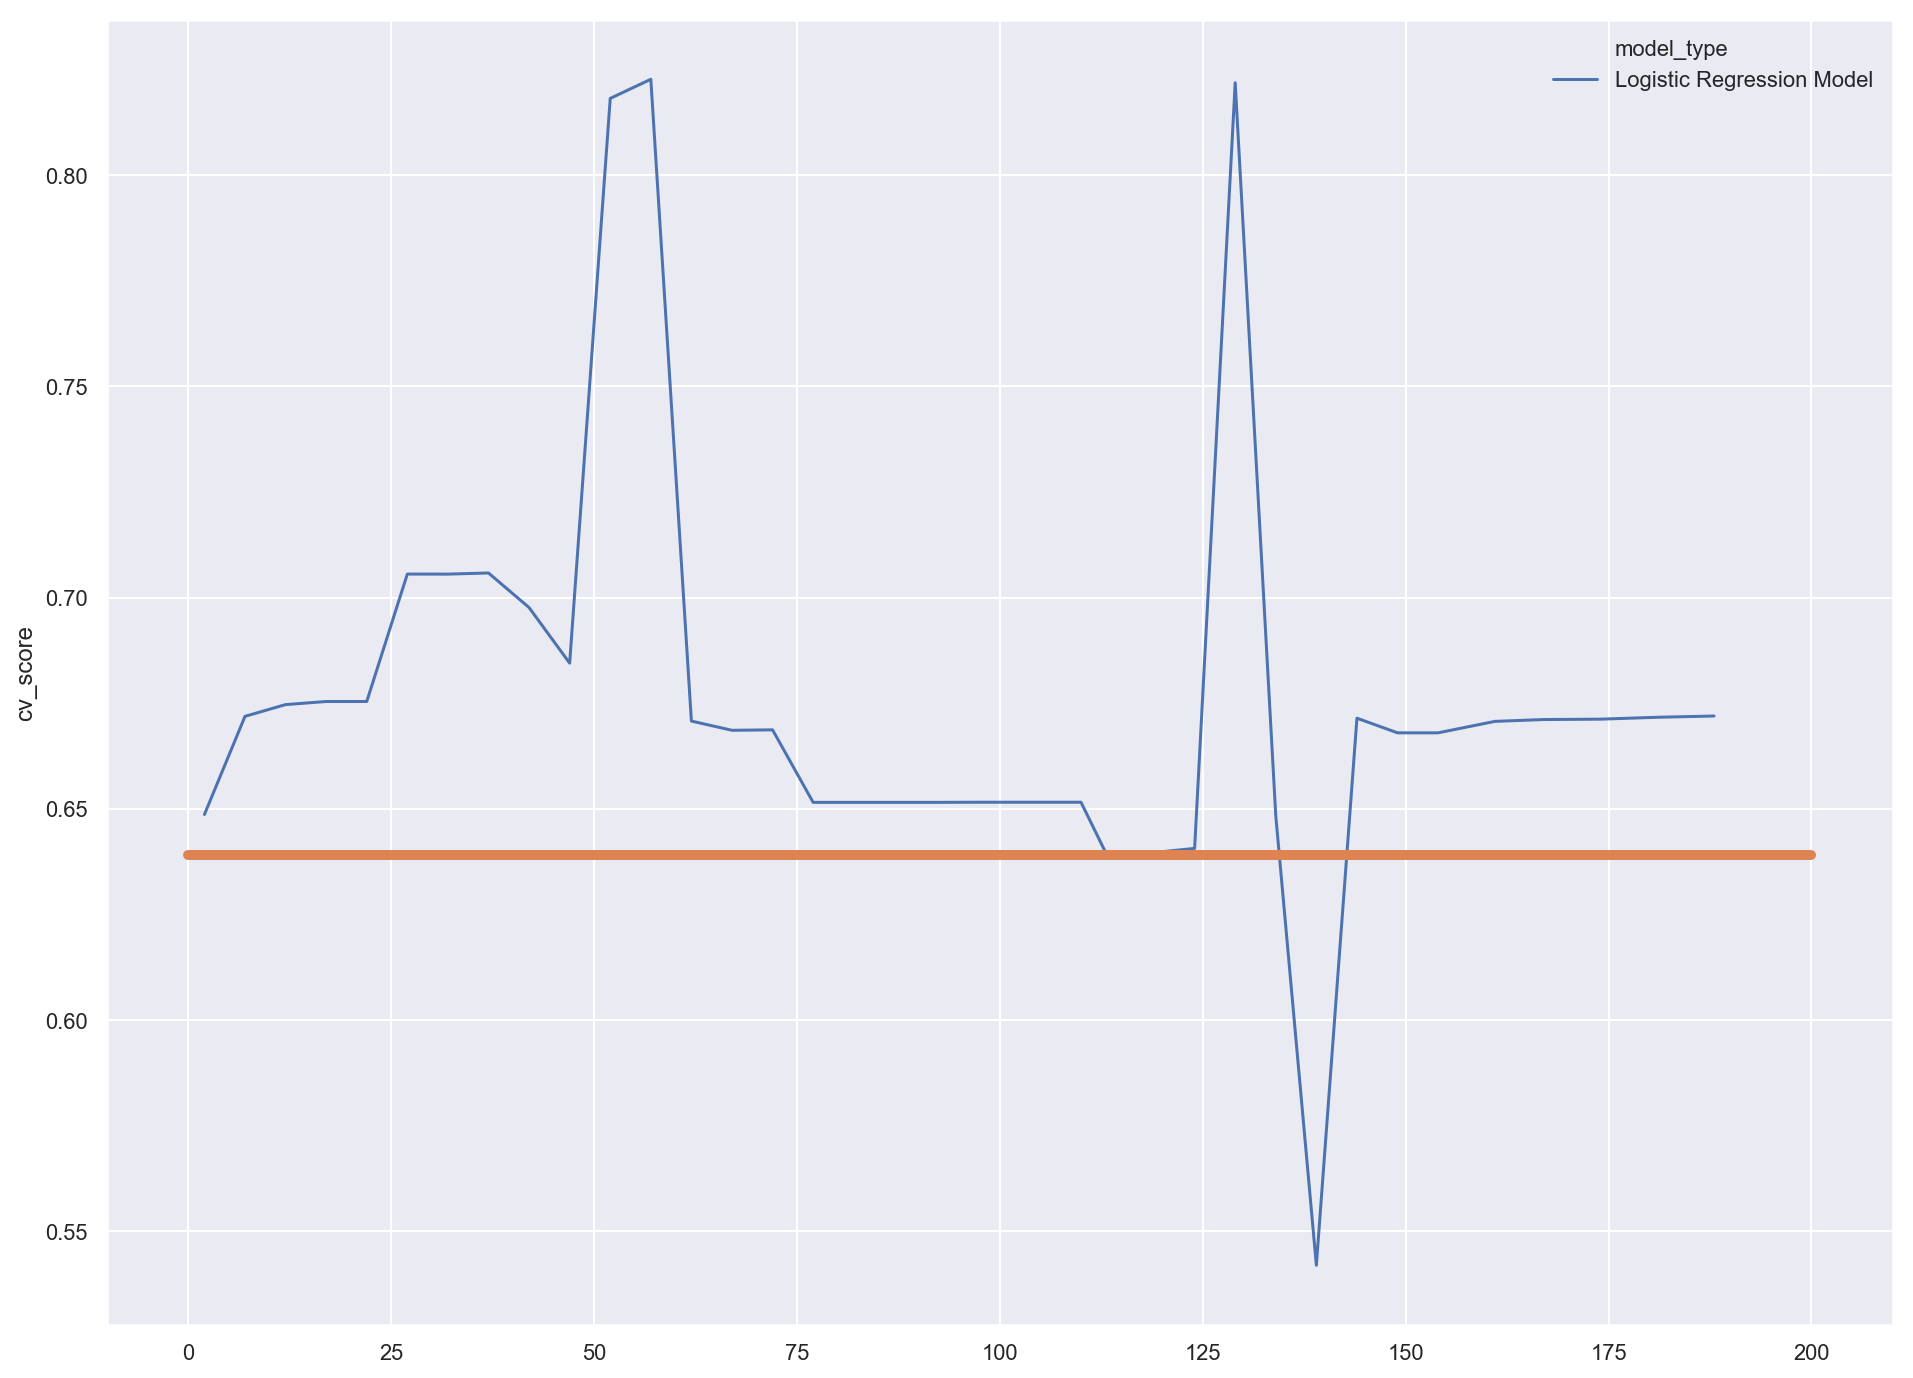

In [106]:
plt.figure(figsize=(16,12))
sns.lineplot(x=model_tracker[model_tracker['model_type']=='Logistic Regression Model'].index,y=model_tracker[model_tracker['model_type']=='Logistic Regression Model'].cv_score,hue=model_tracker.model_type[model_tracker['model_type']=='Logistic Regression Model']);
sns.lineplot(x=(0,200),y=(0.639,0.639),lw=5);